### Filename we're going to play with

In [1]:
filename = "data/pilotcompiled.csv"

In [2]:
stimuli_number = 9
response_type_list = c('during')
trial_types = c('during')
response_names = c('During')
catch_trial_number = 10 # what it's set at at the moment, arbitrary
condition_number = 3

In [3]:
trace_cutoff = 2 # mean dissimilarity for physically identical colours must be below this
antitrace_cutoff = 3.5 # mean dissimilarity accepted for maximally physically different colours must be above this
rt_cutoff = 600 # mean reaction times must be above this

In [4]:
exclude_noncompliant = FALSE

In [5]:
plotsubjects = TRUE
plotsubjects_mixed = TRUE
plot_within_between = FALSE
plotexpsummary = FALSE
across = FALSE
population = FALSE

In [6]:
# colors for the labels
# changed for this mixed version
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9',"#00A9FF",'#0000FF','#AA00FF',"#FF00AA")
abcolors <- sort(colors)

eccens.colors <- c(
    'Foveal #FF0000',
    'Foveal #FFAA00',
    'Foveal #AAFF00',
    'Foveal #00FF00',
    'Foveal #00FFA9',
    "Foveal #00A9FF",
    'Foveal #0000FF',
    'Foveal #AA00FF',
    "Foveal #FF00AA",
    'Peripheral #FF0000',
    'Peripheral #FFAA00',
    'Peripheral #AAFF00',
    'Peripheral #00FF00',
    'Peripheral #00FFA9',
    "Peripheral #00A9FF",
    'Peripheral #0000FF',
    'Peripheral #AA00FF',
    "Peripheral #FF00AA")

inverted.colors <-  c('#FF0000','#FF00AA','#AA00FF','#0000FF','#00A9FF','#00FFA9','#00FF00','#AAFF00','#FFAA00')

### Initialisations

In [7]:
# live dangerously, get rid of pesky warnings
oldw <- getOption("warn")
options(warn = -1)

In [8]:
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(MASS)
library(Matrix)
library(reshape2)
library(ape) # stats
library(vegan) # stats
library(RColorBrewer)
library(cocor)
library(DescTools)
library(reshape2)
library(grid)
library(ggplotify)
library(fclust)
library(plot.matrix)


Attaching package: 'tidyr'

The following object is masked _by_ '.GlobalEnv':

    population


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package:

In [9]:
# rainbowcloud theme for plotting, stolen from: 
# https://micahallen.org/2018/03/15/introducing-raincloud-plots/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com
raincloud_theme = theme(
text = element_text(size = 10),
axis.title.x = element_text(size = 16),
axis.title.y = element_text(size = 16),
axis.text = element_text(size = 14),
axis.text.x = element_text(angle = 45, vjust = 0.5),
legend.title=element_text(size=16),
legend.text=element_text(size=16),
legend.position = "right",
plot.title = element_text(lineheight=.8, face="bold", size = 16),
panel.border = element_blank(),
panel.grid.minor = element_blank(),
panel.grid.major = element_blank(),
axis.line.x = element_line(colour = 'black', size=0.5, linetype='solid'),
axis.line.y = element_line(colour = 'black', size=0.5, linetype='solid'))

In [10]:
# stealing ability to make flat violin plots
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")

### Functions we're going to use to do the analysis later

#### Miscellaneous

In [11]:
# check our N 
get_n <- function(datadf){
    n <- length(unique(datadf$subject))
    print(paste("There are",n,"unique subjects"))
    return(n)
}

In [12]:
# get plot eccentricity labels
ploteccen <- function(datadf){
    if(datadf$Circle_1[1] == -1){
            label1 = 'Foveal'
        } else {
            label1 = 'Peripheral'
        }
        if(datadf$Circle_2[1] == -1){
            label2 = 'Foveal'
        } else {
            label2 = 'Peripheral'
        }
    return(c(label1,label2))
}

e2l <- function(eccentricity){
    if(eccentricity == -1){
        return('Foveal')
    } else {
        return('Peripheral')
    }
}

l2e <- function(eccentricity){
    if(eccentricity == 'Foveal'){
        return(-1)
    } else {
        return(1)
    }
}

#### Dissimilarity Matrices

In [13]:
# obtain dissimilarity matrices with particular eccentricity values from dataframes
dissimdata <- function(datadf, colors, eccentricity1, eccentricity2){
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datatemp = subset(datadf, Circle_1 == eccentricity1)
    datatemp = subset(datatemp, Circle_2 == eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [14]:
# plot a dissimilarity matrix
dissimplot <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = similarity)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [15]:
# plot a shuffled dissimilarity matrix, for visualisation purposes only
dissimplot_shuffled <- function(datadf){
    # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    datadf$similarity = sample(datadf$similarity, replace=FALSE) # shuffle colour 2
    
     plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    plot <- plot + geom_raster(aes(fill = similarity)) +
                labs(title = paste("SHUFFLED\n",label1, " - ", label2)) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [16]:
df2mat_asymmetry <- function(datadf,eccentricity1,eccentricity2){
    
    datadf <- dissimdata(datadf, colors, eccentricity1, eccentricity2)
    
    # aggregate over the remaining columns of interest
    nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    nmdsdata$Color_1 <- nmdsdata$Group.1
    nmdsdata$Color_2 <- nmdsdata$Group.2

    nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","similarity"))  # get rid of unnecessary columns
    nmdsmatrix <- spread(nmdsdata, Color_1, similarity)
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    matdf <- as.data.frame(nmdsmatrix - t(nmdsmatrix))
    matdf$colorset <- c(abcolors)
    num_colors <- length(colors)
    matdf <- matdf %>% gather(othercolor,asymmetry ,1:num_colors)
    return(matdf)
}

In [17]:
# plot an asymmetry matrix
# BROKEN - FIX AS PER YUSUKE'S CODE: https://docs.google.com/presentation/d/1TQZ2ohqZfeWYq0TATobiSZHlkJJuZZ6vqbAmOPQaUDI/edit#slide=id.p1
asymmetry_plot <- function(datadf,eccentricity1,eccentricity2,colors){
    
    # labeling the types
    label1 <- "Presented"
    label2 <- "Response Screen"
    
    datadf <- df2mat_asymmetry(datadf,eccentricity1,eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datadf$colorset <- with(datadf, factor(colorset, levels = colors))
    datadf$othercolor <- with(datadf, factor(othercolor, levels = colors))
    
    plot <- ggplot(datadf, aes(x = colorset, y = othercolor)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = asymmetry)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("blue","white","red"), limits = c(-4,4)) +
                guides(fill=guide_legend(title="Dissimilarity\nAsymmetry"))
    return(plot)
}

In [18]:
# making a matrix symmetric. Stolen from dclone: https://rdrr.io/github/datacloning/dclone/src/R/make.symmetric.R
make.symmetric <-function(x)
{
    if (dim(x)[1] != dim(x)[2])
        stop("'x' is not a square matrix")
    rval <- t(x)
    m <- (x[lower.tri(x)] + rval[lower.tri(rval)]) / 2
    rval[lower.tri(rval)] <- m
    rval <- t(rval)
    rval[lower.tri(rval)] <- m
    rval
}

In [19]:
# obtain dissimilarity matrices that correspond to all of a subjects' judgements
# symmeterises by taking the mean
dissimdata.full <- function(datadf, colors=colors, duplicate=TRUE){
    
    # first, get a full label for each trial
    datadf <- subset(datadf, trial_type != 'catch')
    
    datadf <- datadf %>%
        rowwise() %>%
        mutate(color.eccen1 = paste(c(e2l(Circle_1),Color_1),collapse=' - ')) %>%
        mutate(color.eccen2 = paste(c(e2l(Circle_2),Color_2),collapse=' - ')) %>%
        mutate(color.eccen = paste(sort(c(e2l(Circle_1),Color_1,e2l(Circle_2),Color_2)),collapse=':')) %>%
        ungroup()

    # take the average across symmetric trials (e.g. C-blue, P-green & C-green, P-blue)
    
    datadf <- aggregate(datadf, by = list(datadf$color.eccen),mean)
    datadf$color.eccen <- datadf$Group.1
    
    
    
    # get some labels back for plotting below that we destroyed in the process
    datadf$color.eccen.sacrifice <- datadf$color.eccen

    datadf <- datadf %>% separate(color.eccen.sacrifice, c("color.1","color.2","eccen.1","eccen.2"),':')
    
    

    datadf$color1.eccen1 <- paste(datadf$eccen.1,datadf$color.1)
    datadf$color2.eccen2 <- paste(datadf$eccen.2,datadf$color.2)
    
    # duplicate some rows if we want to plot a full matrix - for aesthetic reasons
    # I'm sorry for how ugly this is but I had so many bugs making it for unfathomable reasons (to me) that I'm not
    # going to change it now. Feel free to clean it up for me
    if(duplicate){
        tempdf <- subset(datadf,(color.1 != color.2))
        
        tempdf$color1.eccen1.temp <- tempdf$color1.eccen1
        tempdf$color2.eccen2.temp <- tempdf$color2.eccen2

        tempdf$color1.eccen1 <- tempdf$color2.eccen2.temp
        tempdf$color2.eccen2 <- tempdf$color1.eccen1.temp
             
        
        tempdf <- subset(tempdf, select = -c(color1.eccen1.temp, color2.eccen2.temp))
        
        tempdf2 <- subset(tempdf, substr(tempdf$color.eccen, 16, nchar(tempdf$color.eccen)) == ':Foveal:Peripheral')
        
        tempdf <- subset(tempdf, substr(tempdf$color.eccen, 16, nchar(tempdf$color.eccen)) != ':Foveal:Peripheral')
        
        tempdf2$temp1 <- tempdf2$color1.eccen1
        tempdf2$color1.eccen1 <- paste('Foveal',substr(tempdf2$temp1,nchar(tempdf2$temp1)-7+1,nchar(tempdf2$temp1)))
        tempdf2$temp2 <- tempdf2$color2.eccen2
        tempdf2$color2.eccen2 <- paste('Peripheral',substr(tempdf2$temp2,nchar(tempdf2$temp2)-7+1,nchar(tempdf2$temp2)))
        debug <- subset(tempdf2, select=c(color1.eccen1,temp1,color2.eccen2,temp2))
        tempdf2 <- subset(tempdf2, select = -c(temp1,temp2))
        
        
        datadf <- rbind(datadf,tempdf,tempdf2)
    }
    
    datadf$color <- substr(datadf$color.eccen, 1, 15) # get a colour pair label
    datadf$color1 <- substr(datadf$color, 1, 7)
    datadf$color2 <- substr(datadf$color, 9, 15)
    
     # refactor the levels so they can be plotted properly later if need be
   datadf$color1.eccen1 <- with(datadf, factor(color1.eccen1, levels = eccens.colors))
   datadf$color2.eccen2 <- with(datadf, factor(color2.eccen2, levels = eccens.colors))

    
    return(datadf)
}

In [20]:
# rotate a vector
rotate.vec <- function(vec, rotation){
    indexshift = round((rotation/360)*length(vec),0)
    if (indexshift == 0){
        return(vec)
    } else {
        return(c(tail(vec, -indexshift), head(vec, indexshift)))
    }
}

In [21]:
# swap the labels
matswap <- function(mat,mode='random',rotation=90){
    
    labels <- rownames(mat)
    if(mode=='random'){
        labels.swapped <- sample(labels)
    } else if (mode=='inversion'){
        labels.swapped <- c('#FF0000','#FF00AA','#AA00FF','#0000FF','#00A9FF','#00FFA9','#00FF00','#AAFF00','#FFAA00')
    } else if (mode=='rotation'){
        labels.swapped <- rotate.vec(labels,rotation)
    }
    
    rownames(mat) <- labels.swapped
    colnames(mat) <- labels.swapped
    
    # sort the matrix
    mat <- mat[, sort(colnames(mat))][sort(rownames(mat)),]
    
    return(mat)
    
}

In [207]:
# label the rows with the two colours independent of arbitrary ordering
dissimplot.full <- function(datadf, mode='standard',rotation=90,dependent='dissimilarity'){
        
    if(dependent=='RT'){
                datadf$similarity <- log10(datadf$similarity)
    }
    
    plot <- ggplot(datadf, aes(x = color1.eccen1, y = color2.eccen2)) 
    
    if(mode=='standard'){
        color.list <- c(colors,colors)
    } else if (mode=='inversion'){
        color.list <- c(colors, inverted.colors)
    } else if (mode == 'rotation'){
        color.list <- c(colors, rotate.vec(colors,rotation))
    }
    plot <- plot + theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    
    
    # dissimilarity plot
    if(dependent=='dissimilarity'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"),
                                    limits=c(0,7),
                                    breaks=c(0,1,2,3,4,5,6,7)) +
                guides(fill=guide_legend(title="Dissimilarity"))
    }
    if(dependent=='RT'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"),
                                    #limits=c(1000,1600),
                                    #breaks=c(500,1000,2000,3000)
                                    ) +
                guides(fill=guide_legend(title="Log10(RT)"))
    }
    return(plot)
    
}

In [23]:
df2mat.full <- function(datadf,eccentricity1=l2e('Foveal'),eccentricity2=l2e('Foveal')){
 
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datadf <- subset(datadf, Circle_1 == eccentricity1 & Circle_2 == eccentricity2)

    # aggregate over the remaining columns of interest
    datadf <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    datadf$Color_1 <- datadf$Group.1
    datadf$Color_2 <- datadf$Group.2

    datadf = subset(datadf, select = c("Color_1","Color_2","similarity"))  # get rid of unnecessary columns
    datadf <- spread(datadf, Color_1, similarity)
    
    # convert the dataframe to a matrix
    datamatrix <- data.matrix(datadf)
    datamatrix <- datamatrix[,-1] # get rid of the labels in the first column, it messes up the code
    datamatrix <- make.symmetric(datamatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    rownames(datamatrix) <- colnames(datamatrix)
    
    # sort the matrix
    datamatrix <- datamatrix[, sort(colnames(datamatrix))][sort(rownames(datamatrix)),]
    
    return(datamatrix)
    
}

#### Testing different method using matrix plots

In [205]:
color.eccen.mat <- function(datadf,output='DF',mode='identity',rotation=90,plot=FALSE,dependent='dissimilarity'){
    library('plot.matrix')
    if(dependent=='RT'){
        datadf$similarity <- datadf$response_time
    }
    data <- subset(datadf, select = c(color1.eccen1, color2.eccen2, similarity))
    data <- spread(data, color1.eccen1, similarity)
    row.names <- data$color2.eccen2
    data.mat <- data.matrix(data)
    rownames(data.mat) <- row.names
    data.mat <- data.mat[,-1] # get rid of the redundant first column
    
    # duplicate Foveal x Peripheral matrix
    PF <- data.mat[10:18, 1:9]
    data.mat[1:9,10:18] <- PF
    
    # perform a label swap
    peripheral.labels <- c(10:18)
    if(mode == 'random'){
        swap.vec <- sample(peripheral.labels) # pick a random ordering of the peripheral labels
    } else if (mode == 'rotate'){
        swap.vec <- rotate.vec(peripheral.labels,rotation=rotation)
    } else if (mode == 'invert'){
        swap.vec <- match(inverted.colors,colors) + 9
    }
    if(mode != 'identity'){ # do the swap
        data.mat[10:18,] <- data.mat[swap.vec, ] # reorder the rows
        data.mat[,10:18] <- data.mat[, swap.vec] # reorder the columns
    }
        
    
    # plot the data
    if(plot){
        plot(data.mat, col=gray.colors(8, start=0, end=1, gamma=0.75, rev=TRUE),
         xlab = 'Fovea                                      Periphery',
        ylab = 'Fovea                                      Periphery')
    }
    
    
    # choose output type
    if(output == 'DF'){
        data <- as.data.frame(as.table(data.mat))
        colnames(data) <- c("color1.eccen1","color2.eccen2","similarity")
        return(data)
    } else if (output == 'matrix'){
        return(data.mat)
    }
}

#### Multidimensional Scaling Plots

In [25]:
# turn a dataset into a matrix
df2mat <- function(datadf,eccentricity1,eccentricity2,dependent='color'){
    
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datadf = subset(datadf, Circle_1 == eccentricity1 & Circle_2 == eccentricity2)
    
    if(dependent == 'position'){ # using stimulus location as a negative control
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$bin1, datadf$bin2),FUN=mean)
        nmdsdata$bin1 <- nmdsdata$Group.1
        nmdsdata$bin2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("bin1","bin2","similarity"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, bin1, similarity)
    } else { # color as per normal
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
        nmdsdata$Color_1 <- nmdsdata$Group.1
        nmdsdata$Color_2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","similarity"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, Color_1, similarity)
    }
    
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    
    # having 0 dissimilarity between identical objects messes up the algorithm
    # changing the 0 values to an arbitrarily small value, but this is not a good long-term solution
    # need to find a better way of doing this
    nmdsmatrix[nmdsmatrix == 0] <- 0.01
    
    
    nmdsmatrix <- make.symmetric(nmdsmatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    return(nmdsmatrix)
}

In [26]:
# convert a standard matrix to a distance matrix
mat2dist <- function(mat){
    
    return(distmat <- as.dist(mat))
}

Non-metric multidimensional scaling (NMDS)

In [27]:
# find the nmds fit for a dataset
nmdsfit <- function(distmatrix){
      
    fit <- isoMDS(distmatrix,k=2, maxit=100)
    return(fit)
}

In [28]:
# plot the nmds fit
nmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = points.1, y = points.2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Non-metric MDS',sep=' - '))
    return(plot)
}

Classical multidimensional scaling

In [29]:
# find the cmds fit for a dataset
cmdsfit <- function(distmatrix){
    
    fit <- cmdscale(distmatrix,k=2)
    return(fit)
}

In [30]:
# plot the cmds fit
cmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = V1, y = V2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Classical MDS',sep=' - '))
    return(plot)
}

#### Some control measure plots

Reaction time vs. similarity judgements

In [31]:
# similarity judgement histogram
simhistplot <- function(datadf){
    
   plot <- ggplot(datadf, aes(x = similarity)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
}

simhistplot_summary <- function(datadf,QDM='FULL'){
    
    if(QDM == 'FP'){
        datadf <- subset(datadf, ((Circle_1 == l2e('Foveal') & Circle_2 == l2e('Peripheral')) |
                                 (Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Foveal'))
                                 ))
    }
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x = similarity)) + 
    geom_line(stat='count',aes(y = ..prop..,group = subject),color='#CC9933') +
    geom_line(stat='count',aes(y = ..prop..),size=1.5) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = paste(QDM,'Dissimilarity')) +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
    
}

In [199]:
# reaction time for each similarity
rsplot <- function(datadf){
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time)) + 
    stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Reaction Time (ms)') +
    theme(legend.position = "none") +
    
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered
    
    return(plot)
}

rsplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time,group = subject, color = subject)) + 
    stat_summary(fun.y = mean, geom = "line", size=0.8) + 
    stat_summary(fun.y = mean, geom = "line", size=2.5, aes(group=1)) + # add a population summary
    #stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Mean Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered 
    
    return(plot)
    
}

In [33]:
# reaction time raincloud plot
rsplot_raincloud <- function(datadf,xtype='linear'){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    datadf$similarity <- as.character(datadf$similarity) # necessary for visualisation
    
    ylabtext = 'Reaction Time (ms)'
    
    plot <- ggplot(datadf, aes(y = response_time, x = similarity, fill = similarity)) +
            geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8) +
            geom_point(aes(y = response_time, color = similarity),
                   position = position_jitter(width = .15), size = .5, alpha = 0.8) +
            geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, alpha = 0.5) +
            expand_limits(x = 5.25) +
            guides(fill = FALSE) +
            guides(color = FALSE) +
            scale_color_brewer(palette = "Spectral") +
            scale_fill_brewer(palette = "Spectral") +
            xlab('Dissimilarity') + ylab("Reaction Time (ms)")
            # coord_flip() +
            theme_bw() +
            raincloud_theme
    
    if(xtype == 'log'){
        plot <- plot + scale_y_continuous(trans='log10') + ylim(0,15000)
    } else{
        plot <- plot + ylim(0,5000)
    }
    
    return(plot)
}

In [34]:
# correlation between reaction times and similarity judgements
# grouping at individual trial, individual participant, experiment or entire population level
rt_similarity_cor <- function(datadf,level='participant'){
        
    if(level=="participant"){
        datadf <- datadf %>% 
                group_by(subject) %>% 
                mutate(rt_similarity_correlation = cor(similarity,response_time))
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)

                
    }
    return(datadf)
    
}

rt_similarity_plot <- function(datadf,xlabel='BLANK'){
    
    datadf <- rt_similarity_cor(datadf)
    
    datadf[xlabel] = xlabel
    
    plot <- ggplot(datadf,aes(x=xlabel,y=rt_similarity_correlation)) + 
                geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                theme(text = element_text(size=15)) + xlab("")
                ggtitle(title)
    
    plot <- plot + ylab("Correlation (Spearman)") + ylim(-1,1)
    plot <- plot + geom_hline(yintercept=0, linetype="dashed", color = "blue")
    return(plot)
}

In [35]:
# mean reaction time vs. antitrace-trace difference
rt_difference <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$difference[datadf$subject == ID] = unlist(antitrace_avg(tempdf),use.names=FALSE)[1] - 
                   unlist(trace_avg(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_difference_plot <- function(datadf,xtype='linear'){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(rt_difference(datadf), aes(x=response_time, y=difference)) +
            geom_point() + xlab("Mean Reaction Time") + ylab("Antitrace - Trace")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) # linear line of best fit
    return(plot)
}

In [36]:
# mean reaction time vs. catch trial score
rt_catch <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$catch_score[datadf$subject == ID] = unlist(catch_score(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_catch_plot <- function(datadf,xtype='linear',label=FALSE){
    
    datadf <- rt_catch(datadf)
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x=response_time, y=catch_score)) +
            geom_point() + xlab("Mean Reaction Time") + ylab("Catch Score")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) + ylim(0,1) # linear line of best fit
    #plot <- plot + geom_point(aes(color = subject))
    if(label){
        plot <- plot + geom_text(aes(label = subject),check_overlap=TRUE)
    }
    return(plot)
}

In [37]:
# mean antitrace-trace difference vs. catch trial score
catch_difference <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf1 <- subset(datadf, subject == ID & trial_type!= 'catch') # remove catch trials for difference calculation
        tempdf2 <- subset(datadf, subject == ID) # keep catch trials for score calculation
        datadf$difference[datadf$subject == ID] = 
                   unlist(antitrace_avg(tempdf1),use.names=FALSE)[1] - 
                   unlist(trace_avg(tempdf1),use.names=FALSE)[1]
        datadf$catch_score[datadf$subject == ID] = unlist(catch_score(tempdf2),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

catch_difference_plot <- function(datadf,xtype='linear',label=FALSE){
    
    datadf <- catch_difference(datadf)
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x=difference, y=catch_score)) +
            geom_point() + xlab("Antitrace - Trace") + ylab("Catch Score")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')
    } else{
        plot <- plot
    }
    plot <- plot + geom_smooth(method=lm) + ylim(0,1) # linear line of best fit
    #plot <- plot + geom_point(aes(color = subject))
    if(label){
        plot <- plot + geom_text(aes(label = subject),check_overlap=TRUE)
    }
    return(plot)
}

In [38]:
# trace values vs. trial #
trace_by_trial_plot <- function(datadf,graph='point',mode='relative'){
    
     datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    
    datadf <- subset(datadf, Color_1 == Color_2)
    
    if(mode=='relative'){
        datadf <- datadf %>% group_by(subject) %>% mutate(trialnum = row_number())
    } else{
        datadf$trialnum <- datadf$trial_number
    }
        
    if(graph=='point'){
        plot <- ggplot(datadf, aes(x=trialnum, y = similarity, group = subject, color = subject)) + geom_point()
    } else if (graph == 'boxplot'){
        plot <- ggplot(datadf, aes(x=trialnum,y = similarity, group = trialnum)) + geom_boxplot() #????
    } else if (graph == 'lineplot'){
        plot <- ggplot(datadf, aes(x=trialnum, y = similarity,group=subject, color = subject)) + geom_line()
    }
    
    plot <- plot + ylab('Dissimilarity') +  theme(legend.position='none')
    
    return(plot)
    
}

In [39]:
# subject info
sumplot <- function(datadf){
    
    # change ms to s, add the delay for each trial
    datadf$response_time <- ((datadf$response_time + 0.125*nrow(datadf)) / 1000)
    
    plot <- ggplot(datadf, aes(x=subject, y = response_time)) + 
    stat_summary(fun.y = sum, geom = "bar") + ylim(0,1000) +
    ylab('Response Time Total') + theme(axis.title.x=element_blank(), axis.text.x = element_text(size=20))
    
    return(plot)
}

In [40]:
# plot a correlation distribution
r_distribution_plot <- function(datadf,fisher=TRUE,comparison='FFvPP',title=TRUE){
    
    if(comparison == 'FFvPP'){
        datadf$correlations <- datadf$FFvPP
    } else if (comparison == 'FFvFP'){
        datadf$correlations <- datadf$FFvFP
    } else if (comparison == 'FPvPP'){
        datadf$correlations <- datadf$FPvPP
    }
    
    # return to non-fisher-transformed correlation if applicable
    if(!fisher){
        datadf$correlations <- FisherZInv(datadf$correlations)
    }
    
    datadf$magnification <- as.character(datadf$magnification) # needed for axes to work properly
    datadf$stimulus_radius <- as.character(datadf$stimulus_radius)
    
    # actually plot shit
    plot <- ggplot(datadf, aes(y=correlations, x=stimulus_radius,
                               color=mode, 
                               #fill=mode,
                               #group=stimulus_radius
                              )
                              ) + 
    geom_point(position=position_dodge(width=0.75)) + 
    geom_boxplot(aes(alpha=0.01)) + 
    scale_alpha(guide='none') +
    xlab('Stimulus Size (DVA)') + labs(color = 'Swap')
    
    if(fisher){
        plot <- plot + ylab('Fisher-Transformed Correlation') + ylim(-0.6,2.6)
    } else {
        plot <- plot + ylab('Correlation') + ylim(-0.2,1)
    }
    
    if(title){
        plot <- plot + ggtitle(paste("Comparison:",comparison,"---","Magnification:",datadf$magnification[1])) +
            theme(plot.title = element_text(hjust = 0.5))
    }
    
    return(plot)
    
}
#r_distribution_plot(testdf,fisher=TRUE)


#### Check their screen size & viewing distance

In [41]:
# screen size in mm
screen_size <- function(datadf){
    
    datadf <- subset(datadf, trialcode == 'centermouse') # make sure calibrations have finished first
    
    width <- as.numeric(substr(as.character(datadf$screen_size_x)[1],1,6))
    height <- as.numeric(substr(as.character(datadf$screen_size_y)[1],1,6))
    
    # use pythagoras to just get the hypotenuse. Subjects have a fixed 16/9 aspect ratio so these are all comparable
    return(sqrt(width*width + height*height))
}

In [42]:
# viewing distance in mm
view_distance <- function(datadf){
    return(as.numeric(substr(as.character(datadf$viewer_distance)[1],1,6)))
}

### Statistics

Useful functions

In [43]:
# compare the foveal and peripheral matrices to each other
fvp_test <- function(datadf,dependent='color'){
    
    if(dependent=='position'){
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else{
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    }
    #Fovea vs Periphery
    test <- mantel(fmatrix, pmatrix, method="spearman",permutations = 9999)
    return(test)
}

In [44]:
# compare the each of the foveal and peripheral matrices to a random uniform distribution using a ... test
# not actually sure this is conceptually possible or even makes sense
rand_test <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    # compare
    ftest <- 
    ptest <- 
    return(list("ftest" = ftest, "ptest" = ptest)) # use index of result to get the foveal or peripheral comparison
}



In [45]:
# calculate trace average, small values presumably indicate subjects not just saying everything is completely dissimilar
# will also need a complementary method to deal with them saying everything is the same? Might be an inappropriate
# a-priori imposition though, I probably can't tell people how similar different colours should be...

trace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    
    return(list( (sum(diag(fmatrix))/nrow(fmatrix)), (sum(diag(pmatrix))/nrow(pmatrix))))
}

In [46]:
# calculate the average of the main or off-main diagonal for a QDM for a group of subjects
group_trace <- function(datadf,QDM='FP',mode='trace'){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    trace.vec <- vector()
    
    for (subjectid in subjectlist){
        tempdf <- subset(datadf, subject == subjectid)
        if(QDM=='FF'){
            matrix <- df2mat.full(tempdf, l2e('Foveal'),l2e('Foveal'))
        } else if (QDM == 'FP'){
            matrix <- df2mat.full(tempdf, l2e('Foveal'),l2e('Peripheral'))
        } else if (QDM == 'PP'){
            matrix <- df2mat.full(tempdf, l2e('Peripherial'),l2e('Peripheral'))
        }
        
        #obtain relevant value
        if(mode == 'trace'){
            trace <- sum(diag(matrix))/nrow(matrix)
        } else if (mode=='antitrace'){
            trace <- antitrace(matrix)
        }
        
        trace.vec <- c(trace.vec, trace)
    }
    return(trace.vec)
}

In [47]:
group_trace_plot <- function(datadf,QDM='FP'){
    
    subjects <- unique(datadf$subject)
    Main <- group_trace(datadf,QDM=QDM,mode='trace')
    Antimain <- group_trace(datadf,QDM=QDM,mode='antitrace')
    
    tempdf <- data.frame(subjects,Main,Antimain)
    tempdf <- tempdf %>% gather(feature,value,Main:Antimain)
    
    plot <- ggplot(tempdf, aes(x=feature,y=value)) + 
        geom_boxplot() + geom_point() + geom_line(aes(group=paired)) +
        ylab("Dissimilarity") + xlab("") + scale_x_discrete(limits=rev(levels(as.factor(tempdf$feature))))
    return(plot)
}

In [48]:
# find the 'anti-trace' of a matrix
antitrace <- function(mat){
    
    sum = 0
    for(i in (1:nrow(mat))){
        k = as.numeric(mat[ i, as.integer((ncol(mat)/2+i) %% ncol(mat))+1 ])
        sum = sum + k
    }
    return(sum/nrow(mat))
}

In [49]:
# calculates the average of the 'anti-trace', the values I'd expect to be the most dissimilar.
# this may not be an appropriate imposition on subjects...

antitrace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    return(list(antitrace(fmatrix), antitrace(pmatrix)))
}

In [50]:
# just get a simple measure of if the matrices are correlated, irrespective of treating them as distance matrices
# updated from df2mat to df2mat.full
# half version just uses half the matrix as it's symmetrical anyway
matrixcor <- function(datadf,M1='FF',M2='PP',dependent='color', mode='half'){
    
    if(dependent == 'position'){
        # first, turn the dataframe into the relevant matrices
        matrix1 <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        matrix2 <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else {
        if((M1 == 'FF' & M2 == 'PP') | (M1 == 'PP' & M2 == 'FF')){
            matrix1 <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'))
            matrix2 <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))   
        } else if((M1 == 'FF' & M2 == 'FP') | (M1 == 'FP' & M2 == 'FF')) {
            matrix1 <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'))
            matrix2 <- df2mat.full(datadf, l2e('Foveal'), l2e('Peripheral'))
        } else if ((M1 == 'FP' & M2 == 'PP') | (M1 == 'PP' & M2 == 'FP')){
            matrix1 <- df2mat.full(datadf, l2e('Foveal'), l2e('Peripheral'))
            matrix2 <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
        }
    }
    
    # just take the upper half (including the diagonal)
    if(mode=='half'){
        matrix1 <- matrix1[upper.tri(matrix1, diag = TRUE)]
        matrix2 <- matrix2[upper.tri(matrix2, diag = TRUE)]
    }
    
    return(cor(c(matrix1), c(matrix2), method = "spearman"))
}

In [51]:
# get median reaction time
rt_avg <- function(datadf){
    return(median(datadf$response_time))
}

Run the analysis

In [52]:
# stats for all the subjects
allsubjectstats <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects


    for (subjectid in subjectlist){
        
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        cat("SUBJECT: ",subjectid,'\n') # print subject id
        print("Mantel Test: ")
        print(fvp_test(subjectdf))
        print("Matrices correlation: ")
        print(matrixcor(subjectdf))
        print("Quality control measures:")
        print("Trace average:")
        print(trace_avg(subjectdf))
        print("Anti-trace average:")
        print(antitrace_avg(subjectdf))
    }
}

In [53]:
# function to aggregate everyone's data together
aggregate_df <- function(datadf,dependent='color'){

    # aggregate everyone's data together for the matrices
    everyonedata <- aggregate(datadf, by=list(
        datadf$Color_1,
        datadf$Color_2,
        datadf$Circle_1,
        datadf$Circle_2,
        datadf$bin1,
        datadf$bin2
        ), FUN=mean, 
    )

    # correct the column names
    everyonedata$Color_1 <- everyonedata$Group.1
    everyonedata$Color_2 <- everyonedata$Group.2
    everyonedata$Circle_1 <- everyonedata$Group.3
    everyonedata$Circle_2 <- everyonedata$Group.4
    everyonedata$bin1 <- everyonedata$Group.5
    everyonedata$bin2 <- everyonedata$Group.6
    
    return(everyonedata)
}

In [54]:
# compliance checker
compliance_checker <- function(datadf,eccentricity,trace_cutoff,antitrace_cutoff){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    n_subject = length(subjectlist)
    trace_fail = 0
    antitrace_fail = 0
    
    if(eccentricity == 'Foveal'){
        e_ind = 1
    } else if (eccentricity == 'Peripheral'){
        e_ind = 2
    }

    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        if(trace_avg(subjectdf)[e_ind] > trace_cutoff){
            trace_fail = trace_fail + 1
        }
        if(antitrace_avg(subjectdf)[e_ind] < antitrace_cutoff){
            antitrace_fail = antitrace_fail + 1
        }
    }
    print(paste("Trace non-compliance: ",trace_fail,"/",n_subject))
    print(paste("Anti-trace non-compliance: ",antitrace_fail,"/",n_subject))
}

In [55]:
# calculate the catch trial score for a subject
catch_score <- function(datadf){
    datadf <- subset(datadf, trial_type == 'catch')
    datadf$correct <- ifelse(datadf$similarity == datadf$catch_vals, 1, 0) # determine whether they got the catch trials right
    score <- sum(datadf$correct)/nrow(datadf) # get the score
    return(score)
}

In [56]:
# catch trial checker
catch_trial_checker <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Catch scores")
    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid)
        
        catch_trials <- subset(subjectdf, trial_type == 'catch')
        catch_num = nrow(catch_trials)
        catch_correct = nrow(subset(catch_trials, catch_vals == similarity))
        
        print(paste("Subject",subjectid,":",catch_correct,"/",catch_num))
    }
}

In [57]:
# screen parameters
screen_parameters <- function(datadf,individual=FALSE){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Screen Parameters")
    screen_fail = 0
    viewing_fail = 0
    for (subjectid in subjectlist){

        subjectdf = subset(datadf, subject == subjectid)
        
        screen_size <- round(screen_size(subjectdf)/10,1)
        viewing_distance <- round(view_distance(subjectdf)/10,1)
        
        if(screen_size < 20){screen_fail = screen_fail + 1}
        if(viewing_distance < 30){viewing_fail = viewing_fail + 1}
        
        if(individual){
            print(paste("Subject",subjectid,":"))
            print(paste("Screen size:",screen_size,"cm"))
            print(paste("Viewing distance:",viewing_distance,"cm"))
            print("")
        }
        
        
    }
    print("")
    print(paste("Screen size issues:",screen_fail,"/",length(subjectlist)))
    print(paste("Viewing distance issues:",viewing_fail,"/",length(subjectlist)))
}

In [58]:
# summary stats
summarystats <- function(datadf,dependent='color'){
    if(dependent=='position'){
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf),'position'))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf),'position'))
    } else {
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf)))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf)))
    }
    
    
    print("Foveal compliance:")
    compliance_checker(datadf,'Foveal')
    print("Peripheral compliance:")
    compliance_checker(datadf,'Peripheral')
}

## Actual Data Analysis Time

#### Initial data pre-processing, before getting to the subject level

In [59]:
datadf = read.csv(filename)
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later


In [60]:
#weird bug in a subject data for arielzj_fvp_2stim_fixed_point25dva_v2_20_08_30 (1)
datadf <- subset(datadf, (subject != 660294531) & (subject != 21721408) & (subject != 238973028))

In [61]:
# remove practice trial data
datadf <- subset(datadf, blockcode == 'experiment')

In [62]:
# changing color values from RGB to hex for graphing purpose
datadf$Color_1 <- as.character(datadf$Color_1)
datadf$Color_1 <- revalue(datadf$Color_1, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))
datadf$Color_2 <- as.character(datadf$Color_2)
datadf$Color_2 <- revalue(datadf$Color_2, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))



In [63]:
# changing from int indicators in the .csv file to more readable labels for eccentricity
foveal = -1
peripheral = 1

In [64]:
# set the maximum and minimum dissimilarity values for later analysis
min_val = 0
max_val = 6

In [65]:
# binning the positions the stimuli were displayed in to use as a control measure later
datadf$bin1 <- as.integer((datadf$Position_1+180) / 40) + 1
datadf$bin2 <- as.integer((datadf$Position_2+180) / 40) + 1

In [66]:
# adding a trial type label
label_eccen_type <- function(datadf){
    datadf <- datadf %>%
    mutate(eccen_type = case_when(Circle_1 == l2e('Foveal') & Circle_2 == l2e('Foveal') ~ 'FF',
                             Circle_1 == l2e('Foveal') & Circle_2 == l2e('Peripheral') ~ 'FP',
                             Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Peripheral') ~ 'PP'))
    return(datadf)
}

In [67]:
datadf <- label_eccen_type(datadf)

Some actual data cleaning

In [68]:
# function to throw out  participants who didn't finish
remove_incomplete <- function(datadf,stimuli_number){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    print(paste(length(subjectlist),"in dataset"))
    print("")
    
    for (ID in subjectlist){ # go through subject by subject
        
        trialnumber = stimuli_number*stimuli_number*condition_number + catch_trial_number
        
        trialsdone <- nrow(subset(datadf, subject == ID))
        print(paste("Subject",ID,"completed",trialsdone,"/",trialnumber))
        
        if ( trialsdone != trialnumber){ # see if they have the appropriate trial numbers
            datadf <- subset(datadf, subject != ID) # dump the subject
        }
    }
    return(datadf)
}

In [69]:
screen_parameters(datadf)

[1] "Screen Parameters"
[1] ""
[1] "Screen size issues: 0 / 150"
[1] "Viewing distance issues: 0 / 150"


In [70]:
# actually throw out the subjects who didn't complete
datadf <- remove_incomplete(datadf,stimuli_number)

[1] "150 in dataset"
[1] ""
[1] "Subject 3248455 completed 253 / 253"
[1] "Subject 9522584 completed 253 / 253"
[1] "Subject 13228849 completed 253 / 253"
[1] "Subject 35587329 completed 253 / 253"
[1] "Subject 35716339 completed 253 / 253"
[1] "Subject 40354804 completed 253 / 253"
[1] "Subject 48341337 completed 253 / 253"
[1] "Subject 50823202 completed 253 / 253"
[1] "Subject 51805023 completed 253 / 253"
[1] "Subject 63991259 completed 253 / 253"
[1] "Subject 75394365 completed 253 / 253"
[1] "Subject 80499026 completed 253 / 253"
[1] "Subject 95990930 completed 2 / 253"
[1] "Subject 98665966 completed 253 / 253"
[1] "Subject 99640956 completed 253 / 253"
[1] "Subject 107179842 completed 37 / 253"
[1] "Subject 120361401 completed 253 / 253"
[1] "Subject 133207874 completed 253 / 253"
[1] "Subject 147071530 completed 253 / 253"
[1] "Subject 168630625 completed 1 / 253"
[1] "Subject 172093576 completed 253 / 253"
[1] "Subject 175331425 completed 12 / 253"
[1] "Subject 176476116 comp

In [71]:
# function to label participants who meet statistical cleaning assumptions
label_noncompliant <- function(datadf,
                               screen_size_cutoff=26,viewing_distance_cutoff=30,rt_cutoff=600,score_cutoff=0.7){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest 
        
        screen_size <- round(screen_size(subjectdf)/10,1)
        viewing_distance <- round(view_distance(subjectdf)/10,1)
        catch_score <- catch_score(subjectdf)
        
        if(catch_score > score_cutoff){ # catch score cutoff
            if(screen_size > screen_size_cutoff){ # screen size cutoff
                if(viewing_distance > viewing_distance_cutoff){ # viewing distance cutoff
                    if(rt_avg(subjectdf) > rt_cutoff){ # rt cutoff
                        datadf$noncompliant[datadf$subject == ID] = 0
                    } else {
                        print(paste("Subject",ID,"reaction time of:",rt_avg(subjectdf),"ms",sep=' ')) # RT fail
                        datadf$noncompliant[datadf$subject == ID] = 1
                    }
                } else {
                    print(paste("Subject",ID,"viewing distance of:",viewing_distance,"cm",sep=' ')) # Viewing distance fail
                    datadf$noncompliant[datadf$subject == ID] = 2
                }
            } else {
                print(paste("Subject",ID,"had a screen size of:",screen_size,"cm",sep=' ')) # Screen size fail
                datadf$noncompliant[datadf$subject == ID] = 3
            } 
      } else {
            print(paste("Subject",ID,"had a catch score of: ",catch_score,sep=' ')) # Catch score faile
            datadf$noncompliant[datadf$subject == ID] = 4
        }
    }
    print(paste(length(unique(datadf$subject[datadf$noncompliant==0])),"of",length(unique(datadf$subject)),
                "were compliant",sep=' '))
    return(datadf)
}

In [72]:
catch_trial_checker(datadf)

[1] "Catch scores"
[1] "Subject 3248455 : 10 / 10"
[1] "Subject 9522584 : 6 / 10"
[1] "Subject 13228849 : 9 / 10"
[1] "Subject 35587329 : 10 / 10"
[1] "Subject 35716339 : 10 / 10"
[1] "Subject 40354804 : 10 / 10"
[1] "Subject 48341337 : 10 / 10"
[1] "Subject 50823202 : 10 / 10"
[1] "Subject 51805023 : 10 / 10"
[1] "Subject 63991259 : 10 / 10"
[1] "Subject 75394365 : 10 / 10"
[1] "Subject 80499026 : 10 / 10"
[1] "Subject 98665966 : 10 / 10"
[1] "Subject 99640956 : 10 / 10"
[1] "Subject 120361401 : 1 / 10"
[1] "Subject 133207874 : 7 / 10"
[1] "Subject 147071530 : 7 / 10"
[1] "Subject 172093576 : 7 / 10"
[1] "Subject 176476116 : 10 / 10"
[1] "Subject 176698125 : 10 / 10"
[1] "Subject 204525930 : 10 / 10"
[1] "Subject 219326440 : 7 / 10"
[1] "Subject 225280441 : 10 / 10"
[1] "Subject 232984941 : 10 / 10"
[1] "Subject 244316230 : 5 / 10"
[1] "Subject 245575217 : 10 / 10"
[1] "Subject 251360273 : 10 / 10"
[1] "Subject 252347716 : 6 / 10"
[1] "Subject 254207207 : 4 / 10"
[1] "Subject 25768669

In [73]:
datadf <- label_noncompliant(datadf)

[1] "Subject 9522584 had a catch score of:  0.6"
[1] "Subject 120361401 had a catch score of:  0.1"
[1] "Subject 133207874 had a catch score of:  0.7"
[1] "Subject 147071530 had a catch score of:  0.7"
[1] "Subject 172093576 had a catch score of:  0.7"
[1] "Subject 219326440 had a catch score of:  0.7"
[1] "Subject 244316230 had a catch score of:  0.5"
[1] "Subject 252347716 had a catch score of:  0.6"
[1] "Subject 254207207 had a catch score of:  0.4"
[1] "Subject 265310712 had a catch score of:  0.1"
[1] "Subject 285550479 had a catch score of:  0.1"
[1] "Subject 307922435 had a catch score of:  0.4"
[1] "Subject 369400829 had a catch score of:  0.7"
[1] "Subject 382104984 had a catch score of:  0"
[1] "Subject 429304075 had a catch score of:  0.4"
[1] "Subject 431543630 reaction time of: 559 ms"
[1] "Subject 463372698 had a catch score of:  0.7"
[1] "Subject 471457102 had a catch score of:  0.3"
[1] "Subject 475089391 had a catch score of:  0.7"
[1] "Subject 497105461 reaction time 

In [74]:
# function to run all these checks at once
validation <- function(datadf){
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    
    for (stimulus in size_list){
        for (scale in magnification_list){
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_radius == stimulus)
            
            print(paste("Magnification",scale,"Stimulus",stimulus))
            tempdf <- remove_incomplete(tempdf,stimuli_number)
            screen_parameters(tempdf, individual=FALSE)
            catch_trial_checker(tempdf)
            label_noncompliant(tempdf)
            print("")
            print("____________________")
            print("")
            
        }
    }
}

In [75]:
validation(datadf)

[1] "Magnification 1 Stimulus 0.1"
[1] "17 in dataset"
[1] ""
[1] "Subject 3248455 completed 253 / 253"
[1] "Subject 9522584 completed 253 / 253"
[1] "Subject 35716339 completed 253 / 253"
[1] "Subject 315222554 completed 253 / 253"
[1] "Subject 336215410 completed 253 / 253"
[1] "Subject 369400829 completed 253 / 253"
[1] "Subject 383674527 completed 253 / 253"
[1] "Subject 401106595 completed 253 / 253"
[1] "Subject 403595429 completed 253 / 253"
[1] "Subject 495185845 completed 253 / 253"
[1] "Subject 636181616 completed 253 / 253"
[1] "Subject 718139824 completed 253 / 253"
[1] "Subject 727174165 completed 253 / 253"
[1] "Subject 823688566 completed 253 / 253"
[1] "Subject 903704841 completed 253 / 253"
[1] "Subject 933150654 completed 253 / 253"
[1] "Subject 964615310 completed 253 / 253"
[1] "Screen Parameters"
[1] ""
[1] "Screen size issues: 0 / 17"
[1] "Viewing distance issues: 0 / 17"
[1] "Catch scores"
[1] "Subject 3248455 : 10 / 10"
[1] "Subject 9522584 : 6 / 10"
[1] "Subjec

## Statistical Analysis

### Useful functions & methods

#### Determine within-subject central and peripheral QDM correlation & significance

In [76]:
# return a list of the e1 matrix vs e2 matrix correlations for each subject
# returns Fisher-transformed correlations
# updated matrixcor to use just half of a symmetric matrix

eccentricity_compare_list <- function(datadf,e1='FF',e2='PP'){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
        # updated matrixcor to use only upper half of symmeterised matrices
        correlation_list <- c(correlation_list, FisherZ((matrixcor(subjectdf,M1=e1,M2=e2))))
    }
    return(correlation_list)
}

In [77]:
# shuffle the rows of a matrix
shuffle_matrix <- function(matrix){
    shuffled <- matrix[sample(nrow(matrix)),]
    return(shuffled)
}

In [78]:
# get upper half of a matrix in vector form
halfmat.v <- function(mat){
    halfmat <- c(mat[upper.tri(mat, diag = TRUE)])
    return(halfmat)
}

In [79]:
# return a list of the e1 matrix vs. shuffled e2 matrix for each subject. Pick the # shuffles, default 1000.
# returns Fisher-transformed correlations
# updated df2mat.full to use a symmetric matrix

eccentricity_compare_shuffled_list <- function(datadf,e1='FF',e2='PP',
                                               mode='shuffle', rotation=90, shuffle_num=1000){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
                
        if((e1 == 'FF' & e2 == 'PP') | (e1 == 'PP' & e2 == 'FF')){
            matrix1 <- df2mat.full(subjectdf, l2e('Foveal'), l2e('Foveal'))
            matrix2 <- df2mat.full(subjectdf, l2e('Peripheral'), l2e('Peripheral'))
        } else if ((e1 == 'FF' & e2 == 'FP') | (e1 == 'FP' & e2 == 'FF')){
            matrix1 <- df2mat.full(subjectdf, l2e('Foveal'), l2e('Foveal'))
            matrix2 <- df2mat.full(subjectdf, l2e('Foveal'), l2e('Peripheral'))
        } else if ((e1 == 'PP' & e2 == 'FP') | (e1 == 'FP' & e2 == 'PP')){
            matrix1 <- df2mat.full(subjectdf, l2e('Peripheral'), l2e('Peripheral'))
            matrix2 <- df2mat.full(subjectdf, l2e('Foveal'), l2e('Peripheral'))
        }
        
        #just use upper halves of matrices as they're symmetric
        matrix1 <- halfmat.v(matrix1)
        
        temp_list <- vector()
        for (i in 1:shuffle_num){ #shuffle/swap the second matrix, add values to temp list
            
            if(mode=='shuffle'){
                matrix2_shuffled <- shuffle_matrix(matrix2)
            } else if (mode == 'swap'){
                matrix2_shuffled <- matswap(matrix2,'random')
            } else if (mode == 'invert'){
                matrix2_shuffled <- matswap(matrix2,'inversion')
            } else if (mode == 'rotate'){
                matrix2_shuffled <- matswap(matrix2,'rotation',rotation)
            }
            #just use upper halves of matrices as they're symmetric
            matrix2_shuffled <- halfmat.v(matrix2_shuffled)
            
            temp_list <- c(temp_list, FisherZ(cor(matrix1, matrix2_shuffled, method = "spearman")))
        }
        
        correlation_list <- c(correlation_list,mean(temp_list)) # add the average correlation to the list
        }
    return(correlation_list)
}

In [80]:
# Compare FF, FP & PP correlations under standard, swapped & shuffled modes
# currently just doing a single swap per subject, need to update to multiple swaps
# updated to use full matrix

within_full_compare <- function(df,swap='PP',individual=FALSE){
    
    return_df <- data.frame() # initialisation
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    
    mode.list <- c("identity","random","invert","rotate")
    
    for(mode in mode.list){
        
        # arrays to store the values in
        standard.FFvPP.correlation_list <- vector()
        standard.FFvFP.correlation_list <- vector()
        standard.FPvPP.correlation_list <- vector()

        swapped.FFvPP.correlation_list <- vector()
        swapped.FFvFP.correlation_list <- vector()
        swapped.FPvPP.correlation_list <- vector()

        for (ID in subjectlist){ # go through subject by subject
            subjectdf = subset(df, subject == ID) # select the ID for subject of interest
            data <- dissimdata.full(subjectdf,duplicate = TRUE) # get the data in the format we want

            # get full identity & swapped matrices for the subject
            matrix.identity <- color.eccen.mat(data,output='matrix',mode='identity')
            matrix.swap <- color.eccen.mat(data,output='matrix',mode=mode)
            
            matrix.FF <- matrix.identity[1:9,1:9]
            matrix.FP <- matrix.identity[1:9,10:18]
            matrix.PP <- matrix.identity[10:18,10:18]

            # standard conditions comparison
            if(mode=='identity'){
                standard.FFvPP.r <-  cor(halfmat.v(matrix.FF),halfmat.v(matrix.PP), method = "spearman")
                standard.FFvFP.r <-  cor(halfmat.v(matrix.FF),halfmat.v(matrix.FP), method = "spearman")
                standard.FPvPP.r <-  cor(halfmat.v(matrix.FP),halfmat.v(matrix.PP), method = "spearman")
            } else {
            # swapped conditions comparison
            swap.FF <- matrix.swap[1:9,1:9]
            swap.FP <- matrix.swap[1:9,10:18]
            swap.PP <- matrix.swap[10:18,10:18]
            
            swapped.FFvPP.r <-  cor(halfmat.v(swap.FF),halfmat.v(swap.PP), method = "spearman")
            swapped.FFvFP.r <-  cor(halfmat.v(swap.FF),halfmat.v(swap.FP), method = "spearman")
            swapped.FPvPP.r <-  cor(halfmat.v(swap.FP),halfmat.v(swap.PP), method = "spearman") 
            }
            

            if(individual){
                print(paste("Subject: ",ID))
                print("Standard comparisons")
                print(paste("FF vs PP: ",round(standard.FFvPP.r,2)," - ",
                           "FF vs FP: ",round(standard.FFvFP.r,2)," - ",
                           "FP vs PP: ",round(standard.FPvPP.r,2)))
                print(paste("Swapped comparisons -",swap,"swapped",mode))
                print(paste("FF vs PP: ",round(swapped.FFvPP.r,2)," - ",
                           "FF vs FP: ",round(swapped.FFvFP.r,2)," - ",
                           "FP vs PP: ",round(swapped.FPvPP.r,2)))
            }

            # add them to a list
            if(mode=='identity'){
                standard.FFvPP.correlation_list <- c(standard.FFvPP.correlation_list,FisherZ(standard.FFvPP.r))
                standard.FFvFP.correlation_list <- c(standard.FFvFP.correlation_list,FisherZ(standard.FFvFP.r))
                standard.FPvPP.correlation_list <- c(standard.FPvPP.correlation_list,FisherZ(standard.FPvPP.r))
            } else {
                swapped.FFvPP.correlation_list <- c(swapped.FFvPP.correlation_list,FisherZ(swapped.FFvPP.r))
                swapped.FFvFP.correlation_list <- c(swapped.FFvFP.correlation_list,FisherZ(swapped.FFvFP.r))
                swapped.FPvPP.correlation_list <- c(swapped.FPvPP.correlation_list,FisherZ(swapped.FPvPP.r))
            }
            
            # make a dataframe with all the useful information. Correlations returned are Fisher transformed
            if(mode=='identity'){
                FFvPP <- FisherZ(standard.FFvPP.r)
                FFvFP <- FisherZ(standard.FFvFP.r)
                FPvPP <- FisherZ(standard.FPvPP.r)
                
            } else {
                FFvPP <- FisherZ(swapped.FFvPP.r)
                FFvFP <- FisherZ(swapped.FFvFP.r)
                FPvPP <- FisherZ(swapped.FPvPP.r)
            }
            subject.data <- data.frame(ID,
                                        mode,
                                        FFvPP,
                                        FFvFP,
                                        FPvPP
                                          )
            return_df <- rbind(return_df,subject.data)
            
        }
        # print mean correlations
        if(mode=='identity'){
            print("Standard comparisons")
            print(paste("FF vs PP: ",round(average_correlation(standard.FFvPP.correlation_list),2)," - ",
                   "FF vs FP: ",round(average_correlation(standard.FFvFP.correlation_list),2)," - ",
                   "FP vs PP: ",round(average_correlation(standard.FPvPP.correlation_list),2)))
        } else {
            print(paste("Swapped comparisons -",swap,"swapped -",mode))
            print(paste("FF vs PP: ",round(average_correlation(swapped.FFvPP.correlation_list),2)," - ",
                   "FF vs FP: ",round(average_correlation(swapped.FFvFP.correlation_list),2)," - ",
                   "FP vs PP: ",round(average_correlation(swapped.FPvPP.correlation_list),2)))
        }
      
        
        
    }
    return(return_df)
}

In [81]:
# perform Mann-Whitney U test to compare the within-subject central and peripheral QDMs to randomly shuffled ones
QDM_test <- function(original_correlations,shuffled_correlations){
    
    wilcox.test(original_correlations,shuffled_correlations)
}

#### Determine between-subject central to central QDM correlation & significance

In [82]:
# obtain the subject similarity matrix
# returns Fisher-transformed correlations

i_j_list <- function(datadf, eccentricity1=l2e('Foveal'), eccentricity2=l2e('Foveal'),shuffle=FALSE){
    
    datadf = subset(datadf, Circle_1 == eccentricity1)
    datadf = subset(datadf, Circle_2 == eccentricity2)
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID_i in subjectlist){ 
        subjectdf_i = subset(datadf, subject == ID_i)
        if(shuffle){
            # get their shuffled fovea QDM
            fmatrix_i <- shuffle_matrix(df2mat(subjectdf_i, l2e('Foveal'), l2e('Foveal'))) 
        } else {
            # get their fovea QDM
            fmatrix_i <- df2mat(subjectdf_i, l2e('Foveal'), l2e('Foveal'))
        }
        for (ID_j in subjectlist){
            if(ID_i != ID_j){
                
                subjectdf_j = subset(datadf, subject == ID_j)
                fmatrix_j <- df2mat(subjectdf_j, l2e('Foveal'), l2e('Foveal')) # get their fovea dissimilarity matrix

                correlation_list <- c(correlation_list, 
                                      FisherZ(cor(c(fmatrix_i), c(fmatrix_j), method = "spearman")))
                }
        }
    }
    return(correlation_list)
}

In [83]:
# get a readout of 'average correlation' by Fisher-z transforming the list
# then averaging it, then converting it back
average_correlation <- function(vector){
    average <- mean(vector)
    return(FisherZInv(average))
}

In [84]:
# obtain a vector of k shuffled SSMs
# WARNING: this may take a long time!
shuffled_SSM_correlations <- function(datadf,n_shuffle=1000){
    
    # Jupyter notebooks won't print in realtime, so using this as a workaround
    message("This will take approximately")
    start.time <- Sys.time()
    time_test <- average_correlation(i_j_list(datadf,shuffle=TRUE))
    test.time <- Sys.time()
    time.estimate <- round((test.time-start.time)/60,3)*n_shuffle
    message(as.character(time.estimate))
    message("minutes.")
    
    correlation_list <- vector() # array to store the values in
    
    for(k in 1:n_shuffle){
        correlation_list <- c(correlation_list, average_correlation(i_j_list(datadf,shuffle=TRUE)))
    }
    return(correlation_list)
}

In [85]:
# test where the correlation of the original SSM sits in comparison to the mean correlations of the shuffled SSMs
SSM_test <- function(SSM, SSM_shuffled_list){
    SSM_correlation <- average_correlation(SSM)
    count <- sum(SSM_shuffled_list > SSM_correlation)
    p_value <- round(count/length(SSM_shuffled_list),2)
    print("SSM correlation comparison")
    print(paste("p-value =",format(p_value, nsmall = 2)))
    return(p_value)
}

#### Determine whether within-subject central-peripheral QDM correlation is equal to or greater than between-subject central-central QDMs

In [86]:
# blah

In [87]:
# do the analysis

In [88]:
# correlation plot
corr_plot <- function(correlation_list,title='BLANK',xlabel='BLANK',f2z=FALSE){
    df <- data.frame(correlation_list) # convert list to data frame
    df[xlabel] = xlabel
    
    plot <- ggplot(df,aes(x=xlabel,y=correlation_list)) + 
                geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                theme(text = element_text(size=15)) + xlab("")
                ggtitle(title)
    if(f2z){
                plot <- plot + ylab("Fisher-Transformed Correlation (Spearman)") + ylim(-1,2)
    } else {
                plot <- plot + ylab("Correlation (Spearman)") + ylim(-0.5,1)

    }
    plot <- plot + geom_hline(yintercept=0, linetype="dashed", color = "blue")
    return(plot)
}

In [89]:
within_between_plots <- function(datadf,savestr){
    
    fvp <- fvp_list(datadf)
    i_j <- i_j_list(datadf)
    
    within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
    between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
    within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
    between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

    # save the plots
    title <- textGrob(substr(savestr,nchar('data/')+1,nchar(savestr)))
    g <- arrangeGrob(within_plot,between_plot,
                     within_plot_fisher,between_plot_fisher,
                        nrow = 2, ncol= 2,
                    top = title)

        # save it
    ggsave(paste(savestr,"_Subject_Plots/","correlation plot comparisons_","plot.png",sep=''),g, height = 11, width = 10)
}

In [90]:
# plot within-subject FvP correlations against between-subject FvF correlations
if(plot_within_between){within_between_plots(datadf,savestr)}

Additional experimental summary graphs

In [91]:
# obtains a dataframe of traces for subjects
trace_obtainer <- function(datadf,type="trace"){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    tracedf <- data.frame(subject=character(),ftrace=double(),ptrace=double()) # initialise an output df for the traces
    for (ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        if(type == 'antitrace'){
            subject_trace <- antitrace_avg(tempdf)
        } else if (type == 'difference'){
            subject_trace <- unlist(antitrace_avg(tempdf),use.names=FALSE) - unlist(trace_avg(tempdf),use.names=FALSE)
        }else{
            subject_trace <- trace_avg(tempdf)
        }
        row_df <- data.frame(ID, as.numeric(subject_trace[1]),as.numeric(subject_trace[2]))
        names(row_df) <- c("subject","Fovea x Fovea","Periphery x Periphery")
        tracedf<- rbind(tracedf,row_df)
    }
    return(tracedf)
}

In [92]:
# plot the traces for the subjects individually
trace_plot <- function(datadf,type='trace',grouped=TRUE){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    if(type == 'antitrace'){
        trace_df <- trace_obtainer(datadf,'antitrace')
    } else if (type == 'difference'){
        trace_df <- trace_obtainer(datadf,'difference')
    } else {
        trace_df <- trace_obtainer(datadf)
    }
    
    
    tracedf <- gather(trace_df, key = "eccentricity",value = "trace", 2:3)
    
    if(grouped){
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace)) +
        geom_boxplot() + geom_dotplot(binaxis='y',stackdir='center',dotsize=0.5) +
        theme(legend.position = "none")
    } else {
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace, group = subject, color = subject)) +
        geom_line() + theme(legend.position = "none")
    }
    
    if(type == 'antitrace'){
        plot <- plot + ylim(0,7) + ylab("Mean Physically Maximally Distinct Stimulus Similarity")
    } else if (type == 'difference'){
        plot <- plot + ylim(-6,6) + ylab("Distinct - Identical")
    } else {
        plot <- plot + ylim(0,7) + ylab("Mean Physically Identical Stimulus Similarity")
    }
    
    return(plot)
}

### Do the analysis

First, grab the data cleaned of non-compliant participants

In [93]:
cleandf <- subset(datadf, noncompliant == 0)
get_n(cleandf)

[1] "There are 106 unique subjects"


[1] 106

#### Within-subjects analysis
Next, check what the within-subject correlations are between central and peripheral QDMs.  
Do this by comparing the raw QDMs to shuffled QDMs
Fisher-transform the correlations and compare using a non-parametric test

In [94]:
## Fovea vs. Periphery
# correlation between foveal and peripheral matrices, within subject
within_raw <- eccentricity_compare_list(cleandf,e1='FF',e2='PP')
print(paste("Mean FF-PP correlation:",average_correlation(within_raw)))
# correlation between foveal and shuffled peripheral matrices, within subject
within_shuffled <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='PP') 
print(paste("Mean shuffled FF-PP correlation:",average_correlation(within_shuffled)))
# correlation between foveal and inverted peripheral matrices, within subject
within_inverted <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='PP',mode='invert') 
print(paste("Mean inverted FF-PP correlation:",average_correlation(within_inverted)))
# correlation between foveal and swapped peripheral matrices, within subject
within_swapped <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='PP',mode='swap') 
print(paste("Mean swapped FF-PP correlation:",average_correlation(within_swapped)))

#comparison
QDM_test(within_raw,within_inverted)


ERROR: Error in average_correlation(within_raw): could not find function "average_correlation"


In [174]:
## Fovea vs. FP
## Fovea vs. Periphery
# correlation between foveal and peripheral matrices, within subject
within_raw <- eccentricity_compare_list(cleandf,e1='FF',e2='FP')
print(paste("Mean FF-PP correlation:",average_correlation(within_raw)))
# correlation between foveal and shuffled peripheral matrices, within subject
within_shuffled <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='FP') 
print(paste("Mean shuffled FF-PP correlation:",average_correlation(within_shuffled)))
# correlation between foveal and inverted peripheral matrices, within subject
within_inverted <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='FP',mode='invert') 
print(paste("Mean inverted FF-PP correlation:",average_correlation(within_inverted)))
# correlation between foveal and swapped peripheral matrices, within subject
within_swapped <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='FP',mode='swap') 
print(paste("Mean swapped FF-PP correlation:",average_correlation(within_swapped)))

#comparison
QDM_test(within_raw,within_inverted)

[1] "Mean FF-PP correlation: 0.818136454915304"
[1] "Mean shuffled FF-PP correlation: 0.0716795367081534"
[1] "Mean inverted FF-PP correlation: 0.475912440423678"
[1] "Mean swapped FF-PP correlation: 0.436639771332873"



	Wilcoxon rank sum test with continuity correction

data:  original_correlations and shuffled_correlations
W = 2727.5, p-value = 1.536e-11
alternative hypothesis: true location shift is not equal to 0


In [175]:
## Periphery vs. FP
## Fovea vs. Periphery
# correlation between foveal and peripheral matrices, within subject
within_raw <- eccentricity_compare_list(cleandf,e1='FP',e2='PP')
print(paste("Mean FF-PP correlation:",average_correlation(within_raw)))
# correlation between foveal and shuffled peripheral matrices, within subject
within_shuffled <- eccentricity_compare_shuffled_list(cleandf,e1='FP',e2='PP') 
print(paste("Mean shuffled FF-PP correlation:",average_correlation(within_shuffled)))
# correlation between foveal and inverted peripheral matrices, within subject
within_inverted <- eccentricity_compare_shuffled_list(cleandf,e1='FP',e2='PP',mode='invert') 
print(paste("Mean inverted FF-PP correlation:",average_correlation(within_inverted)))
# correlation between foveal and swapped peripheral matrices, within subject
within_swapped <- eccentricity_compare_shuffled_list(cleandf,e1='FP',e2='PP',mode='swap') 
print(paste("Mean swapped FF-PP correlation:",average_correlation(within_swapped)))

#comparison
QDM_test(within_raw,within_inverted)


[1] "Mean FF-PP correlation: 0.817102669182509"
[1] "Mean shuffled FF-PP correlation: 0.0698456159103496"
[1] "Mean inverted FF-PP correlation: 0.460566181588046"
[1] "Mean swapped FF-PP correlation: 0.398670528347373"



	Wilcoxon rank sum test with continuity correction

data:  original_correlations and shuffled_correlations
W = 2692, p-value = 6.239e-11
alternative hypothesis: true location shift is not equal to 0


#### Between-subjects analysis
How concordant are subjects on similarity judgments given to centrally presented stimuli?
Check the correlation between the central QDM of each subject *i* and *j* and obtain a subject similarity matrix (SSM). If there's no relationship between subjects, these correlations will be unaffected by shuffling the labels on the QDM for subject *i*. 

First up, let's get the standard SSM and see how correlated its entries are.

In [400]:
SSM <- i_j_list(cleandf)
print(paste("Mean between-subject fovea-fovea correlation:",average_correlation(SSM)))

[1] "Mean between-subject fovea-fovea correlation: 0.39334852411956"


Next up, let's do the same thing for shuffled SSMs and get a distribution by doing it 1000 times

In [401]:
SSM_shuffled_list <- shuffled_SSM_correlations(cleandf,n_shuffle=100) #Currently only set to 100!

This will take approximately
16.6
minutes.


Now, let's see where in the distribution of the shuffled SSMs that our actual SSM correlation sits

In [402]:
SSM_test(SSM,SSM_shuffled_list)

[1] "SSM correlation comparison"
[1] "p-value = 0.00"


[1] 0

#### Within-subjects vs. Between-subjects analysis

What we really want to know is whether within-subject central-central, central-peripheral and peripheral-peripheral QDMs are "essentially the same". We assert they are the same if they are more correlated with each other than between-subject central-central QDMs. We can compare these using a non-parametric test on the distribution of Fisher-transformed QDMs

In [404]:
print(paste("Mean fovea-periphery correlation:",average_correlation(within_raw)))
print(paste("Mean between-subject fovea-fovea correlation:",average_correlation(SSM)))

QDM_test(within_raw,SSM)


[1] "Mean fovea-periphery correlation: 0.804521439387299"
[1] "Mean between-subject fovea-fovea correlation: 0.39334852411956"



	Wilcoxon rank sum test with continuity correction

data:  original_correlations and shuffled_correlations
W = 140, p-value = 0.03545
alternative hypothesis: true location shift is not equal to 0


### Power Analysis

In [406]:
test<-c(within_raw,within_raw)
QDM_test(test,SSM)


	Wilcoxon rank sum test with continuity correction

data:  original_correlations and shuffled_correlations
W = 280, p-value = 0.00556
alternative hypothesis: true location shift is not equal to 0


## Tabulation & Plotting Across Conditions

Two parameters we're interested in - (1) stimulus size and (2) cortical magnification. Want to tabulate how various outcome measures change as these parameters change

### Within-subject correlations for each condition

In [130]:
# first, let's grab the data from compliant participants
cleandf <- subset(datadf, noncompliant == 0)
get_n(cleandf)

[1] "There are 106 unique subjects"


[1] 106

In [131]:
# function to print the mean within-subject correlation for each condition, returns a dataframe to plot them
within_correlations_conditions <- function(cleandf,e1='FF',e2='PP',get.correlations=TRUE,compare=TRUE,test=FALSE){
    
    magnification_list <- sort(unique(cleandf$peripheral_scale))
    stim_sizes <- sort(unique(cleandf$stimulus_radius))
    
    return_df <- data.frame() # initialisation
    
    for(scale in magnification_list){
        temp_scale_df <- subset(cleandf, peripheral_scale == scale)
        for(stim_size in stim_sizes){
            tempdf <- subset(temp_scale_df, stimulus_radius == stim_size)
            
            # mark where we are
            print(paste("Magnification",scale,"Stimulus Radius",stim_size))
            get_n(tempdf) # print n values
            print(paste("Median Trace:",round(median(group_trace(tempdf)),2)))
            print(paste("Median Antitrace:",round(median(group_trace(tempdf,mode='antitrace')),2)))
            
            # do all the comparisons, add to a dataframe to return for plotting
            if(compare){
                subject.data <- within_full_compare(tempdf)
                subject.data$magnification <- as.character(scale)
                subject.data$stimulus_radius <- as.character(stim_size)
                return_df <- rbind(return_df,subject.data)
            }
            
            # check if they're significantly different from shuffled data
            if(test){
                correlations <- eccentricity_compare_list(tempdf, e1, e2)
                
                print("Shuffle comparison:")
                within_shuffled <- eccentricity_compare_shuffled_list(tempdf,mode='shuffle') 
                print(QDM_test(correlations,within_shuffled))
                print("Random swap comparison:")
                within_swapped <- eccentricity_compare_shuffled_list(tempdf,mode='swap') 
                print(QDM_test(correlations,within_swapped))
                print("Inverted comparison:")
                within_swapped <- eccentricity_compare_shuffled_list(tempdf,mode='invert') 
                print(QDM_test(correlations,within_swapped))
                print("Rotated (90) comparison:")
                within_swapped <- eccentricity_compare_shuffled_list(tempdf,mode='rotate') 
                print(QDM_test(correlations,within_swapped))
            }
            print("")
        }
    }
    return(return_df)
}

In [132]:
within_distribution_df <- within_correlations_conditions(cleandf)

[1] "Magnification 1 Stimulus Radius 0.1"
[1] "There are 15 unique subjects"
[1] "Median Trace: 1.11"
[1] "Median Antitrace: 4.89"
[1] "Standard comparisons"
[1] "FF vs PP:  0.63  -  FF vs FP:  0.72  -  FP vs PP:  0.66"
[1] "Swapped comparisons - PP swapped - random"
[1] "FF vs PP:  0.28  -  FF vs FP:  0.01  -  FP vs PP:  0.01"
[1] "Swapped comparisons - PP swapped - invert"
[1] "FF vs PP:  0.59  -  FF vs FP:  0.01  -  FP vs PP:  0.01"
[1] "Swapped comparisons - PP swapped - rotate"
[1] "FF vs PP:  0.46  -  FF vs FP:  0.12  -  FP vs PP:  0.15"
[1] ""
[1] "Magnification 1 Stimulus Radius 0.25"
[1] "There are 13 unique subjects"
[1] "Median Trace: 0.78"
[1] "Median Antitrace: 5.44"
[1] "Standard comparisons"
[1] "FF vs PP:  0.84  -  FF vs FP:  0.85  -  FP vs PP:  0.83"
[1] "Swapped comparisons - PP swapped - random"
[1] "FF vs PP:  0.4  -  FF vs FP:  -0.05  -  FP vs PP:  -0.05"
[1] "Swapped comparisons - PP swapped - invert"
[1] "FF vs PP:  0.77  -  FF vs FP:  -0.04  -  FP vs PP:  -0.11"

In [133]:
# make a plot of all the within-subject correlation distributions across eccentricity & magnification
distribution.plots <- function(distributions,transform=FALSE){
    
    if(transform){
        transform.string <- "_transformed"
    } else {
        transform.string <- ""
    }
    
    fixed.df <- subset(distributions, magnification == 1)
    magnified.df <- subset(distributions, magnification != 1)
    
    fixed.FFvPP.plot <- r_distribution_plot(fixed.df, comparison='FFvPP',fisher=transform)
    fixed.FFvFP.plot <- r_distribution_plot(fixed.df, comparison='FFvFP',fisher=transform)
    fixed.FPvPP.plot <- r_distribution_plot(fixed.df, comparison='FPvPP',fisher=transform)
    magnified.FFvPP.plot <- r_distribution_plot(magnified.df, comparison='FFvPP',fisher=transform)
    magnified.FFvFP.plot <- r_distribution_plot(magnified.df, comparison='FFvFP',fisher=transform)
    magnified.FPvPP.plot <- r_distribution_plot(magnified.df, comparison='FPvPP',fisher=transform)
    
    title <- textGrob("Peripheral Swap", gp=gpar(fontsize=35))
    
    allgrob <- arrangeGrob(fixed.FFvPP.plot, fixed.FFvFP.plot, fixed.FPvPP.plot,
                          magnified.FFvPP.plot, magnified.FFvFP.plot, magnified.FPvPP.plot,
                          nrow = 2, ncol = 3, top = title)
    ggsave(paste(savestr,"_Overall_Summary_Plots/Correlation_Distributions_",
                 transform.string,"_plot.png",sep=""),
          allgrob, height = 20, width = 30)
    
}

In [137]:
distribution.plots(within_distribution_df,transform=FALSE)
distribution.plots(within_distribution_df,transform=TRUE)

In [103]:
# make a plot of all the full dissimilarity matrices for each subject
dissimplots.subjects <- function(datadf,dependent='dissimilarity'){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    scale.list <- sort(unique(datadf$peripheral_scale))
    stim.list <- sort(unique(datadf$stimulus_radius))
    
    for(scale in scale.list){
        for(stim in stim.list){
            dir.create(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim,"/",dependent,"/",
                             sep='')) # make a new folder to store the subject plots in
        }
    }
    
    
    for(ID in subjectlist){
        subject.df <- subset(datadf, subject == ID)
        
        subject.plot.standard <- dissimplot.full(color.eccen.mat(dissimdata.full(subject.df),mode='identity',dependent=dependent),dependent=dependent)
        subject.plot.standard <- subject.plot.standard + ggtitle('Standard') + theme(plot.title = element_text(hjust = 0.5))
        
        subject.plot.random <- dissimplot.full(color.eccen.mat(dissimdata.full(subject.df),mode='random',dependent=dependent),dependent=dependent)
        subject.plot.random <- subject.plot.random + ggtitle('Random') + theme(plot.title = element_text(hjust = 0.5))
        
        subject.plot.invert <- dissimplot.full(color.eccen.mat(dissimdata.full(subject.df),mode='invert',dependent=dependent),dependent=dependent)
        subject.plot.invert <- subject.plot.invert + ggtitle('Inverted') + theme(plot.title = element_text(hjust = 0.5))
        
        subject.plot.rotate <- dissimplot.full(color.eccen.mat(dissimdata.full(subject.df),mode='rotate',dependent=dependent),dependent=dependent)
        subject.plot.rotate <- subject.plot.rotate + ggtitle('Rotated (90)') + theme(plot.title = element_text(hjust = 0.5))
        
        scale <- subject.df$peripheral_scale[1]
        stim.size <- subject.df$stimulus_radius[1]
        title <- textGrob(paste(as.character(ID),"-",
                                "Magnification:", scale,
                                "Stimulus Size:", stim.size
                                ),
                                gp=gpar(fontsize=35))
        
        g <- arrangeGrob(subject.plot.standard, subject.plot.random,
                        subject.plot.invert, subject.plot.rotate,
                        nrow = 2, ncol=2, top = title)
        
        ggsave(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim.size,"/",dependent,"/",
                     dependent,"_matrix","_ID_",ID,"_",
                     scale,"_",stim.size,
                     "_plot.png",
                     sep=''),g, height = 20, width = 20)
    }
}

In [137]:
# make a plot of all the dissimilarity & RT matrices for each subject
QDM.RT.subjects <- function(datadf){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    scale.list <- sort(unique(datadf$peripheral_scale))
    stim.list <- sort(unique(datadf$stimulus_radius))
    
    for(scale in scale.list){
        for(stim in stim.list){
            dir.create(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim,"/",
                             sep='')) # make a new folder to store the subject plots in
        }
    }
    
    
    for(ID in subjectlist){
        subject.df <- subset(datadf, subject == ID)
        
        subject.plot.QDM <- dissimplot.full(color.eccen.mat(dissimdata.full(subject.df),mode='identity',dependent='dissimilarity'),dependent='dissimilarity')
        subject.plot.QDM <- subject.plot.QDM + ggtitle('Dissimilarity') + theme(plot.title = element_text(hjust = 0.5))
        
        subject.plot.RT <- dissimplot.full(color.eccen.mat(dissimdata.full(subject.df),mode='identity',dependent='RT'),dependent='RT')
        subject.plot.RT <- subject.plot.RT + ggtitle('Reaction Time') + theme(plot.title = element_text(hjust = 0.5))
        
        
        scale <- subject.df$peripheral_scale[1]
        stim.size <- subject.df$stimulus_radius[1]
        title <- textGrob(paste(as.character(ID),"-",
                                "Magnification:", scale,
                                "Stimulus Size:", stim.size
                                ),
                                gp=gpar(fontsize=35))
        
        g <- arrangeGrob(subject.plot.QDM, subject.plot.RT,
                        nrow = 1, ncol=2, top = title)
        
        ggsave(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim.size,"/",
                     "QDM_RT_matrix","_ID_",ID,"_",
                     scale,"_",stim.size,
                     "_plot.png",
                     sep=''),g, height = 10, width = 20)
    }
}

In [169]:
QDM.RT.subjects(cleandf)
#dissimplots.subjects(cleandf,dependent='RT')

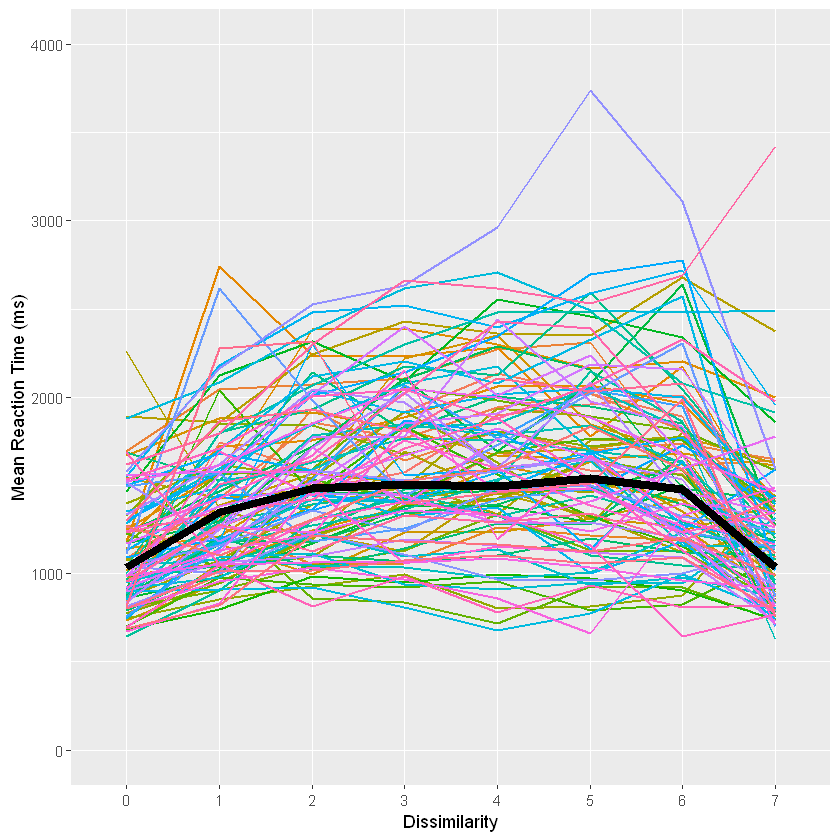

In [200]:
rsplot_summary(cleandf)

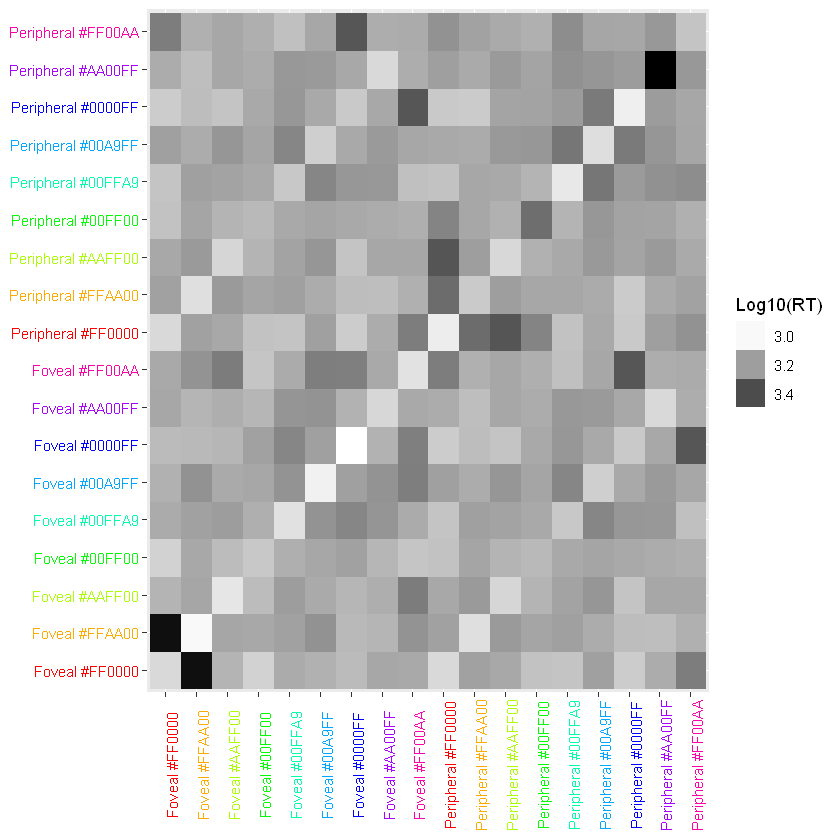

In [208]:
# Make summary QDMs for each population group
dissimplot.full(color.eccen.mat(dissimdata.full(cleandf),mode='identity',dependent='RT'),dependent='RT')

In [144]:
# function to print the mean between-subject correlation for each condition, returns a dataframe to plot them
between_correlations_conditions <- function(cleandf,e1='Foveal',e2='Foveal',test=TRUE){
    
    e1=l2e(e1)
    e2=l2e(e2)
    
    magnification_list <- sort(unique(cleandf$peripheral_scale))
    stim_sizes <- sort(unique(cleandf$stimulus_radius))
    
    return_df <- data.frame() # initialisation
    
    for(scale in magnification_list){
        temp_scale_df <- subset(cleandf, peripheral_scale == scale)
        for(stim_size in stim_sizes){
            tempdf <- subset(temp_scale_df, stimulus_radius == stim_size)
            
            # get the correlations of interest
            correlations <- i_j_list(tempdf, e1, e2)
            print(paste("Magnification",scale,"Stimulus Radius",stim_size,
                        ": mean r = ",average_correlation(correlations)))
            
            # add the correlations to a dataframe for plotting
            correlation_df <- data.frame(correlations, 
                                         magnification = as.character(scale), stimulus_radius = as.character(stim_size))
            return_df <- rbind(return_df,correlation_df)
            
            # check if they're significantly different from shuffled data
            
        }
    }
    return(return_df)
}

In [132]:
between_distribution_df <- between_correlations_conditions(cleandf)

[1] "Magnification 1 Stimulus Radius 0.1 : mean r =  0.30386750186056 2"
[1] "Magnification 1 Stimulus Radius 0.25 : mean r =  0.743885420115348 2"
[1] "Magnification 1 Stimulus Radius 0.5 : mean r =  0.259602057192458 2"
[1] "Magnification 1 Stimulus Radius 1 : mean r =  0.73464721185944 2"
[1] "Magnification 4.5 Stimulus Radius 0.1 : mean r =  0.599518183268645 2"
[1] "Magnification 4.5 Stimulus Radius 0.25 : mean r =  0.376763615450412 2"
[1] "Magnification 4.5 Stimulus Radius 0.5 : mean r =  0.640412930100809 2"
[1] "Magnification 4.5 Stimulus Radius 1 : mean r =  0.39334852411956 2"


In [155]:
# test within-vs-between distributions
within_vs_between <- function(cleandf){
    
    magnification_list <- sort(unique(cleandf$peripheral_scale))
    stim_sizes <- sort(unique(cleandf$stimulus_radius))
    
    return_df <- data.frame() # initialisation
    
    for(scale in magnification_list){
        temp_scale_df <- subset(cleandf, peripheral_scale == scale)
        for(stim_size in stim_sizes){
            tempdf <- subset(temp_scale_df, stimulus_radius == stim_size)
            
            within_correlations <- eccentricity_compare_list(tempdf, 'Foveal', 'Peripheral')
            between_correlations <- i_j_list(tempdf, l2e('Foveal'), l2e('Foveal'))
            
            print(paste("Magnification",scale,"Stimulus Radius",stim_size))
            print(paste("Mean fovea-periphery correlation:",average_correlation(within_correlations)))
            print(paste("Mean between-subject fovea-fovea correlation:",average_correlation(between_correlations)))

            print(QDM_test(within_correlations,between_correlations))
            print("")
        }
    }        
}

In [156]:
within_vs_between(cleandf)

[1] "Magnification 1 Stimulus Radius 0.1"
[1] "Mean fovea-periphery correlation: 0.586389688833031"
[1] "Mean between-subject fovea-fovea correlation: 0.30386750186056"

	Wilcoxon rank sum test with continuity correction

data:  original_correlations and shuffled_correlations
W = 294, p-value = 0.1582
alternative hypothesis: true location shift is not equal to 0

[1] ""
[1] "Magnification 1 Stimulus Radius 0.25"
[1] "Mean fovea-periphery correlation: 0.714690291571861"
[1] "Mean between-subject fovea-fovea correlation: 0.743885420115348"

	Wilcoxon rank sum test with continuity correction

data:  original_correlations and shuffled_correlations
W = 124, p-value = 0.5201
alternative hypothesis: true location shift is not equal to 0

[1] ""
[1] "Magnification 1 Stimulus Radius 0.5"
[1] "Mean fovea-periphery correlation: 0.791039281555879"
[1] "Mean between-subject fovea-fovea correlation: 0.259602057192458"

	Wilcoxon rank sum test with continuity correction

data:  original_correlations 

### Between Conditions

In [199]:
testdf <- subset(cleandf, subject == 63991259)
testmat <- df2mat(testdf, l2e('Foveal'),l2e('Foveal'))

In [200]:
testmat

#0000FF,#00A9FF,#00FF00,#00FFA9,#AA00FF,#AAFF00,#FF0000,#FF00AA,#FFAA00
0.01,1.50,5.00,2.50,2.00,5.50,7.00,7.00,6.50
1.50,0.01,2.00,2.50,4.00,4.00,7.00,6.00,7.00
5.00,2.00,0.01,1.50,6.50,1.50,7.00,6.50,4.00
2.50,2.50,1.50,0.01,5.50,2.50,6.50,6.00,5.00
2.00,4.00,6.50,5.50,0.01,6.00,6.00,1.50,7.00
5.50,4.00,1.50,2.50,6.00,0.01,6.50,6.50,2.50
7.00,7.00,7.00,6.50,6.00,6.50,0.01,4.00,3.00
7.00,6.00,6.50,6.00,1.50,6.50,4.00,0.01,4.00
6.50,7.00,4.00,5.00,7.00,2.50,3.00,4.00,0.01


In [207]:
clust <- Fclust(testmat,k=5)

The standard FkM algorithm has been chosen
The default options have been set, to specify different options, use FKM 


In [211]:
kclust <- FKM(testmat, k=5)
kclust


 Fuzzy clustering object of class 'fclust' 
 
 Number of objects: 
 9
 
 Number of clusters: 
 5
 
 Clustering index values: 
SIL.F k=5 
0.3866621 

 
 Closest hard clustering partition: 
Obj 1 Obj 2 Obj 3 Obj 4 Obj 5 Obj 6 Obj 7 Obj 8 Obj 9 
    2     2     5     5     4     5     3     1     3 

 Membership degree matrix (rounded): 
      Clus 1 Clus 2 Clus 3 Clus 4 Clus 5
Obj 1   0.04   0.74   0.03   0.11   0.07
Obj 2   0.02   0.88   0.01   0.03   0.06
Obj 3   0.01   0.04   0.01   0.01   0.92
Obj 4   0.05   0.30   0.05   0.06   0.55
Obj 5   0.00   0.00   0.00   1.00   0.00
Obj 6   0.03   0.06   0.04   0.03   0.85
Obj 7   0.04   0.01   0.92   0.02   0.01
Obj 8   1.00   0.00   0.00   0.00   0.00
Obj 9   0.17   0.09   0.48   0.09   0.18

 Available components: 
 [1] "U"         "H"         "F"         "clus"      "medoid"    "value"    
 [7] "criterion" "iter"      "k"         "m"         "ent"       "b"        
[13] "vp"        "delta"     "stand"     "Xca"       "X"         "D"     

In [209]:
Fclust.index(clust)

The default value alpha=1 has been set for computing SIL.F 


PC         PE        MPC        SIL      SIL.F         XB 
0.71465819 0.60456751 0.64332273 0.41656990 0.42130298 0.08687633

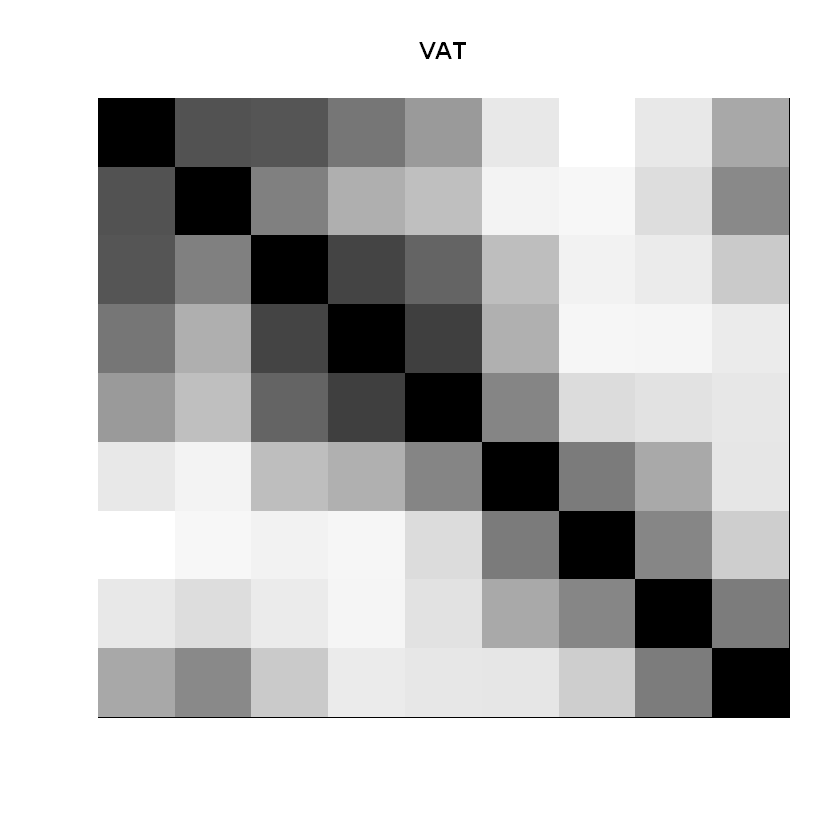

In [204]:
VAT(testmat)

## Plot Stuff

### Plot summary of all subjects

#### Individual subjects

In [82]:
# plot summary data for all the subjects individually
allsubjectsplot <- function(datadf,savestr){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects

    dir.create(paste(savestr,"Subject_Plots",sep='_')) # make a new folder to store the subject plots in

    for (subjectid in subjectlist){
        print(paste("Processing subject:",subjectid,sep=' '))
        subjectplot(datadf, subjectid,savestr)
    }
}

In [83]:
# make a plot of the key summary data for a subject - single trial type version
subjectplot <- function(datadf, subjectid,savestr){
    
    datadf = subset(datadf, subject == subjectid) # select the ID for subject of interest
    for (trial_condition in trial_types){
            subjectdf = subset(datadf, trial_type == trial_condition) # just pick one trial type at a time
    
    
        if(subjectdf$trial_type[1] != 'after_1'){
            FP = TRUE
        } else {
            FP = FALSE
        }

        # FF Matrix plot
        FFmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Foveal'), l2e('Foveal')),colors)



        # PP Matrix plot
        PPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

        # FF CMDS plot
        FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                            abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))



        # PP CMDS plot
        PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

        # FF nMDS plot
        FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                            abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))



        # PP nMDS plot
        PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

        # Similarity judgements
        simplot <- simhistplot(subjectdf)
        # Reaction times
        reactionplot <- rsplot(subjectdf)
        # summary plot
        rainplot <- rsplot_raincloud(subjectdf,'log')

        # trace plots
        traceplot <- trace_plot(subjectdf)
        antiplot <- trace_plot(subjectdf,'antitrace')
        differenceplot <- trace_plot(subjectdf,'difference')

        # asymmetry plot
        asymplot <- asymmetry_plot(subjectdf,l2e('Foveal'),l2e('Foveal'),colors)

        # title
        if(subjectdf$noncompliant[1]){
            title <- textGrob(paste("ID:",as.character(subjectid),"|","Catch Score:",catch_score(datadf),
                              "Screen size:",round(screen_size(subjectdf)/10,1),"cm",
                              "Viewing distance:",round(view_distance(subjectdf)/10,1),"cm"),
                              gp=gpar(col="red",fontsize=35))
        } else {
            title <- textGrob(paste("ID:",as.character(subjectid),"|","Catch Score:",catch_score(datadf),
                              "Screen size:",round(screen_size(subjectdf)/10,1),"cm",
                              "Viewing distance:",round(view_distance(subjectdf)/10,1),"cm"),
                              gp=gpar(col="blue",fontsize=35))
        }
    
        if(FP){

            # FP Matrix plot
            FPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Foveal'), l2e('Peripheral')),colors)

            # FP CMDS plot
            FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # FP nMDS plot
            FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # put all the plots together
            g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, simplot,
                        FFcmds, FPcmds, PPcmds, reactionplot,
                        FFnmds, FPnmds, PPnmds, rainplot,
                        traceplot, antiplot, differenceplot, 
                        nrow = 4, ncol=4, top = title)

            exp_type <- trial_condition
            ggsave(paste(savestr,"_Subject_Plots/",exp_type,"_ID_",subjectid,"_plot.png",sep=''),
                     g, height = 40, width = 40)
        } else {
            # put all the plots together
            g <- arrangeGrob(FFmatrix, PPmatrix, simplot, traceplot,
                        FFcmds, PPcmds, reactionplot, antiplot,
                        FFnmds, PPnmds, rainplot, 
                        nrow = 3, ncol=4, top = title)

            exp_type <- trial_condition
            ggsave(paste(savestr,"_Subject_Plots/",exp_type,"_ID_",subjectid,"_plot.png",
                     sep=''),g, height = 30, width = 40)
        }
    }
}

In [184]:
if(plotsubjects){
    allsubjectsplot(datadf,savestr)
}

[1] "Processing subject: 99640956"
initial  value 9.276396 
iter   5 value 7.325384
iter  10 value 7.203836
iter  10 value 7.198301
iter  10 value 7.197487
final  value 7.197487 
converged
initial  value 6.671118 
iter   5 value 5.261996
final  value 5.246469 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 10.157103 
iter   5 value 7.124059
iter   5 value 7.121951
iter   5 value 7.121448
final  value 7.121448 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 133207874"
initial  value 13.369375 
iter   5 value 9.529546
final  value 9.456198 
converged
initial  value 9.874137 
iter   5 value 7.434489
iter  10 value 6.775011
iter  15 value 5.207787
iter  20 value 5.070027
iter  20 value 5.066969
iter  20 value 5.066113
final  value 5.066113 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 12.651813 
iter   5 value 8.919114
final  value 8.802303 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 176698125"
initial  value 28.526248 
iter   5 value 14.928916
iter  10 value 8.912166
final  value 8.804291 
converged
initial  value 38.612566 
iter   5 value 15.412105
final  value 13.786846 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 32.323878 
iter   5 value 23.793532
iter  10 value 20.528060
iter  15 value 18.450728
iter  20 value 18.234636
iter  25 value 17.906580
final  value 17.840002 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 204525930"
initial  value 7.710417 
iter   5 value 5.178159
final  value 5.150940 
converged
initial  value 6.708022 
iter   5 value 3.703469
final  value 3.498202 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 7.281070 
iter   5 value 5.909321
final  value 5.890110 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 265310712"
initial  value 28.869852 
iter   5 value 17.689313
final  value 17.222011 
converged
initial  value 21.957683 
iter   5 value 18.229215
final  value 18.061142 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 27.143424 
iter   5 value 21.274711
iter  10 value 18.515213
iter  10 value 18.502932
iter  10 value 18.502932
final  value 18.502932 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 281640697"
initial  value 17.299879 
iter   5 value 12.186712
final  value 12.150389 
converged
initial  value 16.615514 
iter   5 value 10.540329
final  value 10.388478 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 12.028323 
iter   5 value 9.555578
final  value 9.525368 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 475089391"
initial  value 17.161175 
iter   5 value 9.998890
iter  10 value 9.564586
final  value 9.520915 
converged
initial  value 15.961226 
iter   5 value 8.988723
iter  10 value 8.265802
final  value 8.245331 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 11.979670 
iter   5 value 8.499101
final  value 8.254990 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 518373039"
initial  value 15.686401 
iter   5 value 11.588644
final  value 11.488775 
converged
initial  value 24.520319 
iter   5 value 19.099108
iter   5 value 19.083964
iter   5 value 19.083964
final  value 19.083964 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 19.993789 
iter   5 value 11.716685
final  value 11.317109 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 789921315"
initial  value 26.013336 
iter   5 value 16.703398
iter  10 value 8.787402
iter  15 value 8.209995
iter  15 value 8.207134
iter  15 value 8.207132
final  value 8.207132 
converged
initial  value 29.256043 
iter   5 value 17.581339
iter  10 value 12.301230
iter  15 value 10.980823
final  value 10.966779 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 32.625926 
final  value 32.625926 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 947430341"
initial  value 29.106080 
iter   5 value 24.195012
iter  10 value 22.414269
final  value 22.143886 
converged
initial  value 34.287119 
iter   5 value 21.987324
final  value 20.490350 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 35.927084 
iter   5 value 24.829682
iter  10 value 21.932416
final  value 21.714132 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


#### New mixed trial type version analysis

In [62]:
# matrix to define layout for the mixed trial type plot
mixed_hlay <- rbind (c(1,2,3,4,5,6),
                     c(7,8,9,10,11,12),
                     c(13,14,15,16,17,18))

In [63]:
# names for the x axis
col_plot_list <- c('FF Matrix', 'FF nMDS', 'PP Matrix', 'PP nMDS', 'RT', 'Dissim Freq')

In [65]:
# make a plot of the key summary data for a subject - mixed trial type version
subject_mixed_plot <- function(datadf,savestr){
    
    dir.create(paste(savestr,"Mixed_Trial_Type_Plots", sep='_'))
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    
    for (subjectid in subjectlist){ # do for each subject
        
        k = 0 # counter
        plot_list <- list() # list to store the plots in as we're making them
        subjectdf = subset(datadf, subject == subjectid) # select the ID for subject of interest

        for (trial_condition in trial_types){
            type_df = subset(subjectdf, trial_type == trial_condition) # just pick one trial type at a time
            
            # FF Matrix plot
            FFmatrix <- dissimplot(dissimdata(type_df, colors, l2e('Foveal'), l2e('Foveal')),colors)
            k = k + 1
            plot_list[[k]] <- as.grob(FFmatrix)
            
            # FF nMDS plot
            FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(type_df,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
            k = k + 1
            plot_list[[k]] <- as.grob(FFnmds)

            # PP Matrix plot
            PPmatrix <- dissimplot(dissimdata(type_df, colors, l2e('Peripheral'), l2e('Peripheral')),colors)
            k = k + 1
            plot_list[[k]] <- as.grob(PPmatrix)

            # PP nMDS plot
            PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(type_df,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
            k = k + 1
            plot_list[[k]] <- as.grob(PPnmds)

            # rt rain plot
            rainplot <- rsplot_raincloud(type_df)
            k = k + 1
            plot_list[[k]] <- as.grob(rainplot)
            # Similarity judgements
            simplot <- simhistplot(subjectdf)
            k = k + 1
            plot_list[[k]] <- as.grob(simplot)

        }

        # save the plots
        yaxis <- textGrob("Trial Type", gp=gpar(fontsize=30), rot=90)
        xaxis <- textGrob("", gp=gpar(fontsize=30))

        title <- textGrob(paste("ID:",subjectid,"|","Catch Score:",catch_score(subjectdf)),gp=gpar(fontsize=35))

        g <- arrangeGrob(grobs = plot_list, ncol = 6,nrow = 3,
                         layout_matrix = mixed_hlay)

        g_rowcol_names <- rbind(tableGrob(t(col_plot_list), theme = ttheme_minimal(), rows = ""),
                    cbind(tableGrob(trial_types, theme = ttheme_minimal()),
                          g, size = "last"), size = "last")


        g_titled <- arrangeGrob(g_rowcol_names, top = title, left = yaxis, bottom = xaxis)
        
        savename <- paste(savestr,"_Mixed_Trial_Type_Plots/",subjectid,"_plot.png",sep='')
        ggsave(savename,g_titled, height = 19, width = 39)
    }
}

In [225]:
subject_mixed_plot(datadf,savestr)

ERROR: Error in subject_mixed_plot(datadf, savestr): could not find function "subject_mixed_plot"


### Summary plots

In [180]:
dir.create(paste(savestr,"Summary_Plots",sep='_'))

In [181]:
# matrix to use to define the plot layout, specified manually for now
hlay <- rbind (c(1,4,7,10),
               c(2,5,8,11)#,
               #c(3,6,9,12)
              )

In [182]:
# correlations summary plot
across_experiment_plot <- function(datadf,savestr,laymatrix,dependent,clean=FALSE){
    
    dir.create(paste(savestr,"Overall_Summary_Plots",sep='_'))
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    
    plot_list <- list()
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    # make all the plots
    k = 0
    for (stimulus in size_list){
        for (scale in magnification_list){
            k = k + 1
            if(stimulus == 2){ # 2 stimuli doesn't have any cueing, so it gets an exception
                tempdf <- subset(datadf, stimulus_radius == 2)
            } else {
                tempdf <- subset(datadf, stimulus_radius == stimulus & peripheral_scale == scale)
            }
            
            # make the specific plot
            if(dependent=='correlation'){
                fvp <- fvp_list(tempdf)
                plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
                title <- textGrob("CORRELATION", gp=gpar(fontsize=35))
            } else if (dependent=='RT'){
                plot <- rsplot_summary(tempdf)
                title <- textGrob("REACTION TIME", gp=gpar(fontsize=35))
            } else if (dependent=='dissimilarity'){
                plot <- simhistplot_summary(tempdf)
                title <- textGrob("DISSIMILARITY", gp=gpar(fontsize=35))
            } else if (dependent=='trace'){
                plot <- trace_plot(tempdf)
                title <- textGrob("TRACE", gp=gpar(fontsize=35))
            } else if (dependent=='antitrace'){
                plot <- trace_plot(tempdf,'antitrace')
                title <- textGrob("ANTITRACE", gp=gpar(fontsize=35))
            } else if (dependent=='difference'){
                plot <- trace_plot(tempdf,'difference')
                title <- textGrob("ANTITRACE - TRACE", gp=gpar(fontsize=35))
            } else if (dependent=='asymmetry_matrix'){
                plot <- asymmetry_plot(tempdf,l2e('Foveal'),l2e('Foveal'),colors)
                title <- textGrob("SIMILARITY ASYMMETRY MATRIX", gp=gpar(fontsize=35))
            } else if (dependent == 'trace_by_trial'){
                plot <- trace_by_trial_plot(tempdf,'boxplot')
                title <- textGrob("Trace by Trial", gp=gpar(fontsize=35))
            }
            
            
            plot <- plot + xlab(paste(stimulus,scale,sep=' ')) #  add a label
            
            plot_list[[k]] <- as.grob(plot) # add it to the plot_list
        }
        
    }
    
    # save the plots
    yaxis <- textGrob("Magnification", gp=gpar(fontsize=30), rot=90)
    xaxis <- textGrob("Stimulus Radius (DVA)", gp=gpar(fontsize=30))
    
    g <- arrangeGrob(grobs = plot_list, ncol = length(magnification_list),nrow = length(size_list),
                     layout_matrix = hlay)
    
    g_rowcol_names <- rbind(tableGrob(t(size_list), theme = ttheme_minimal(), rows = ""),
                cbind(tableGrob(magnification_list, theme = ttheme_minimal()),
                      g, size = "last"), size = "last")
    
    g_titled <- arrangeGrob(g_rowcol_names, top = title, left = yaxis, bottom = xaxis)
    
    if(clean){
        savename <- paste(savestr,"_Overall_Summary_Plots/",dependent,"_CLEAN","_plot.png",sep='')
        ggsave(savename,g_titled, height = 20, width = 30)
    }else{
        savename <- paste(savestr,"_Overall_Summary_Plots/",dependent,"_plot.png",sep='')
        ggsave(savename,g_titled, height = 20, width = 30)
    }
    
    return(g_titled)
}

In [183]:
across_experiment_plot(cleandf,savestr,hlay,'RT')

TableGrob (3 x 2) "arrange": 4 grobs
  z     cells    name                  grob
1 1 (2-2,2-2) arrange    gtable[rowhead-fg]
2 2 (1-1,2-2) arrange text[GRID.text.88113]
3 3 (3-3,2-2) arrange text[GRID.text.88155]
4 4 (1-3,1-1) arrange text[GRID.text.88154]

#### Across all experiments

In [202]:
across_all <- function(datadf,savestr,laymatrix,response_type_list,response_names){
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'RT')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'dissimilarity')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'asymmetry_matrix')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'correlation')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'antitrace')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'difference')
    
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'RT',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'dissimilarity',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'asymmetry_matrix',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'correlation',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'antitrace',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'difference',TRUE)
}

In [203]:
if(across){
    across_all(datadf,savestr,hlay,response_type_list,response_names)
}

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` usin

ERROR: Error in across_all(datadf, savestr, hlay, response_type_list, response_names, : unused argument (TRUE)


#### Individual experiment summaries

In [188]:
# generate a summary plot of all the collected data from all the subjects in the experiment
# NEED TO FINISH THIS
expsummaryplot <- function(datadf,savestr,clean=FALSE){
    
    dir.create(paste(savestr,"Exp_Summary_Plots/",sep='_'))
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    stimuli_list <- sort(unique(datadf$stimuli_count))
    
    # make all the plots
    k = 0
    for (stimulus in stimuli_list){
        for (response in response_type_list){
            
            k = k + 1
            if(stimulus == 2){ # 2 stimuli doesn't have any cueing, so it gets an exception
                tempdf <- subset(datadf, stimuli_count == 2)
            } else {
                tempdf <- subset(datadf, stimuli_count == stimulus & response_type == response)
            }
            
            if(response != 'after_1'){
                FP = TRUE
            } else {
                FP = FALSE
            }
            
            # make the specific summary plot
           
            # MATRICES
            everyonedata <- aggregate_df(tempdf)
            
            stim_time <- everyonedata$stim_display_time[1]
            gap <- everyonedata$stim_cue_gap[1]
            cue_time <- everyonedata$cue_display_time[1]
            
            
            # FF Matrix plot
            FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

            # FP Matrix plot
            FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors)

            # PP Matrix plot
            PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

            # CMDS
            # FF CMDS plot
            FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

            FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # FF CMDS plot
            PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
            # NMDS
            # FF nMDS plot
            FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

            # FP nMDS plot
            FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # PP nMDS plot
            PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

            # AUXILIARY plots
            # Similarity judgements
            simplot <- simhistplot_summary(tempdf)
            # Reaction times v1
            reactionplot <- rsplot_summary(tempdf)
            # summary plot
            raincloudplot <- rsplot_raincloud(tempdf,'log')

            # within_between_plots
            fvp <- fvp_list(tempdf)
            i_j <- i_j_list(tempdf)

            within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
            between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
            #within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
            #between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

            # MORE PLOTS
            # trace plots
            traceplot <- trace_plot(tempdf)
            antiplot <- trace_plot(tempdf,'antitrace')
            differenceplot <- trace_plot(tempdf,'difference')
            
            N <- length(unique(tempdf$subject)) # get number of subjects
            
            # save the plots
            if(clean){
                title <- textGrob(paste(stimulus,response,
                                    "stim_duration",stim_time,"gap",gap,"cue_duration",cue_time,
                                    N,"subjects","CLEAN",
                                    sep="_"), gp=gpar(fontsize=35))
            }else{
                title <- textGrob(paste(stimulus,response,
                                    "stim_duration",stim_time,"gap",gap,"cue_duration",cue_time,
                                    N,"subjects",
                                    sep="_"), gp=gpar(fontsize=35))
            }
            
            # put it all together
            if(FP){
                
                g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, within_plot, between_plot,
                                FFcmds,FPcmds, PPcmds, traceplot, antiplot,
                                FFnmds,FPnmds, PPnmds, raincloudplot, differenceplot,
                                simplot, reactionplot, 
                                nrow = 4, ncol=5, top = title)
            } else {
                
                # asymmetry plot
                asymplot <- asymmetry_plot(tempdf,l2e('Foveal'),l2e('Foveal'),colors)
                
                g <- arrangeGrob(FFmatrix,  PPmatrix, within_plot, between_plot, 
                                FFcmds, PPcmds, traceplot,  antiplot,
                                FFnmds, PPnmds, differenceplot, asymplot,
                                simplot, raincloudplot, reactionplot,
                                nrow = 4, ncol=4, top = title)

                
            }
                # save it
            if(clean){
                savename <- paste(savestr,"_Exp_Summary_Plots/",stimulus,"_",response,
                         "_Summary_",N,"_subjects","_CLEAN","_plot.png",sep='')
            }else {
                savename <- paste(savestr,"_Exp_Summary_Plots/",stimulus,"_",response,
                         "_Summary_",N,"_subjects","_plot.png",sep='')
            }
                
                print(savename)
                ggsave(savename,g, height = 38, width = 48)
        }
            
    }
        
}   

### Across the entire population 

In [213]:
# entire population plot
population_plot <- function(datadf,savestr,clean=FALSE){
    
    dir.create(paste(savestr,"Population_Summary_Plots/",sep='_'))
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    # MATRICES
    everyonedata <- aggregate_df(datadf)

    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors)

    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

    # CMDS
    # FF CMDS plot
    FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

    FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

    # FF CMDS plot
    PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    # NMDS
    # FF nMDS plot
    FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

    # FP nMDS plot
    FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

    # PP nMDS plot
    PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

    # AUXILIARY plots
    # Similarity judgements
    simplot <- simhistplot_summary(datadf)
    # Reaction times v1
    reactionplot <- rsplot_summary(datadf)
    # summary plot
    raincloudplot <- rsplot_raincloud(datadf,'log')

    # within_between_plots
    fvp <- fvp_list(datadf)
    i_j <- i_j_list(datadf)

    within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
    between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
    #within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
    #between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

    # MORE PLOTS
    # trace plots
    traceplot <- trace_plot(datadf)
    antiplot <- trace_plot(datadf,'antitrace')
    differenceplot <- trace_plot(datadf,'difference')

    N <- length(unique(datadf$subject)) # get number of subjects

    # save the plots
    if(clean){
        title <- textGrob(paste("Population",
                            N,"subjects","CLEAN",
                            sep="_"), gp=gpar(fontsize=35))
    }else{
        title <- textGrob(paste("Population",
                            N,"subjects",
                            sep="_"), gp=gpar(fontsize=35))
    }
    
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, within_plot, between_plot,
                                FFcmds,FPcmds, PPcmds, traceplot, antiplot,
                                FFnmds,FPnmds, PPnmds, raincloudplot, differenceplot,
                                simplot, reactionplot, 
                                nrow = 4, ncol=5, top = title)
    
     # save it
    if(clean){
        savename <- paste(savestr,"_Exp_Summary_Plots/",
                 "_Summary_",N,"_subjects","_CLEAN","_plot.png",sep='')
    }else {
        savename <- paste(savestr,"_Exp_Summary_Plots/",
                 "_Summary_",N,"_subjects","_plot.png",sep='')
    }

        print(savename)
        ggsave(savename,g, height = 38, width = 48)
}

In [2]:
test <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

test

ERROR: Error in dissimplot(dissimdata(everyonedata, colors, l2e("Foveal"), l2e("Foveal")), : could not find function "dissimplot"


In [214]:
if(plotexpsummary){
    expsummaryplot(datadf,savestr)
    expsummaryplot(datadf,savestr,TRUE)
}

In [215]:
if(population){
    population_plot(datadf,savestr)
    population_plot(datadf,savestr,TRUE)
}

initial  value 10.110642 
iter   5 value 4.776044
iter  10 value 4.309526
final  value 4.276221 
converged
initial  value 9.398094 
iter   5 value 4.759062
iter  10 value 3.994180
final  value 3.981702 
converged
initial  value 5.047839 
iter   5 value 1.323556
iter  10 value 0.944285
iter  15 value 0.841798
iter  20 value 0.821025
final  value 0.817766 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "data/alldata_Exp_Summary_Plots/_Summary_128_subjects_plot.png"
initial  value 3.365119 
iter   5 value 1.843522
iter  10 value 1.615815
iter  15 value 1.571471
final  value 1.567521 
converged
initial  value 5.607216 
iter   5 value 2.817553
iter  10 value 2.443810
final  value 2.402800 
converged
initial  value 4.294241 
iter   5 value 2.475724
iter  10 value 2.280757
final  value 2.271904 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "data/alldata_Exp_Summary_Plots/_Summary_37_subjects_CLEAN_plot.png"


In [ ]:
# position plot (negative control)
positionplot <- function(datadf){
    # MATRICES
    everyonedata <- aggregate_df(datadf)
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors, 'position')
    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors, 'position')
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors, 'position')
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix,
                    nrow = 1, ncol= 3)
     # save it
    ggsave(paste(savestr,"position negative control","plot.png",sep='_'),g, height = 10, width = 30)
}